In [1]:
import numpy as np
import pandas as pd
import optuna
import random

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import xgboost as xgb

import joblib
import pickle

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import normaltest

from sklearn import preprocessing
from sklearn import decomposition
from sklearn import svm
from sklearn import tree
from sklearn import metrics
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

from ctgan import CTGAN

# <center> **Прогнозирование риска сердечного приступа**


Проект основан на данных с платформы Kaggle [Heart Attack Risk Prediction](https://www.kaggle.com/datasets/iamsouravbanerjee/heart-attack-prediction-dataset/data)

Набор данных для прогнозирования риска сердечного приступа служит ценным ресурсом для изучения сложной динамики здоровья сердца и его предикторов. Сердечные приступы или инфаркты миокарда продолжают оставаться серьезной глобальной проблемой здравоохранения, что требует более глубокого понимания их предшественников и потенциальных смягчающих факторов. Этот набор данных включает в себя широкий спектр атрибутов, включая возраст, уровень холестерина, артериальное давление, привычку курить, характер физических упражнений, диетические предпочтения и многое другое, с целью выяснить сложное взаимодействие этих переменных при определении вероятности сердечного приступа. Применяя прогнозную аналитику и машинное обучение для этого набора данных, исследователи и специалисты здравоохранения могут разрабатывать упреждающие стратегии профилактики и лечения сердечно-сосудистых заболеваний. Набор данных является свидетельством коллективных усилий, направленных на улучшение нашего понимания здоровья сердечно-сосудистой системы и прокладывание пути к более здоровому будущему.

Этот набор данных предоставляет полный набор характеристик, имеющих отношение к здоровью сердца и выбору образа жизни, включая специфичные для пациента детали, такие как возраст, пол, уровень холестерина, артериальное давление, частота сердечных сокращений и такие показатели, как диабет, семейный анамнез, привычка к курению, ожирение и потребление алкоголя. Кроме того, учитываются факторы образа жизни, такие как часы физических упражнений, пищевые привычки, уровень стресса и сидячий образ жизни. Учитываются медицинские аспекты, включающие предыдущие проблемы с сердцем, использование лекарств и уровень триглицеридов. Социально-экономические аспекты, такие как доход и географические атрибуты, такие как страна, континент и полушарие, включены. Набор данных, состоящий из 8763 записей пациентов со всего мира, завершается важной функцией бинарной классификации, обозначающей наличие или отсутствие риска сердечного приступа, предоставляя комплексный ресурс для прогнозного анализа и исследований в области сердечно-сосудистых заболеваний.

+ Patient ID - Идентификатор пациента
+ Age - Возраст пациента
+ Sex - Пол
+ Cholesterol - Уровень холестерина
+ Blood Pressure - Кровяное давление (systolic/diastolic)
+ Heart Rate - Частота сердечных сокращений (пульс)
+ Diabetes - Есть ли у пациента диабет (Yes/No)
+ Family History - Семейный анамнез проблем с сердцем (1: Yes, 0: No)
+ Smoking - Курение (1: Smoker, 0: Non-smoker)
+ Obesity - Ожирение (1: Obese, 0: Not obese)
+ Alcohol Consumption - Употребление алкоголя (None/Light/Moderate/Heavy)
+ Exercise Hours Per Week - Количество часов физических упражнений в неделю
+ Diet - Пищевые привычки пациента (Healthy/Average/Unhealthy)
+ Previous Heart Problems - Предыдущие проблемы с сердцем пациента (1: Yes, 0: No)
+ Medication Use - Использование медицинских препаратов пациентом (1: Yes, 0: No)
+ Stress Level - Уровень стресса, о котором сообщил пациент (1-10)
+ Sedentary Hours Per Day - Количество часов сидячей деятельности в день
+ Income - Уровень дохода пациента
+ BMI - Индекс массы тела
+ Triglycerides - Уровень триглицеридов у пациента
+ Physical Activity Days Per Week - Количество физически активных дней в неделю
+ Sleep Hours Per Day - Количество часов сна в день
+ Country - Страна пациента
+ Continent - Континент, где проживает пациент
+ Hemisphere - Полушарие, где проживает пациент
+ Heart Attack Risk - Наличие риска сердечного приступа (1: Yes, 0: No) - Таргет

## <center> **1. Предварительный анализ. Обработка признаков**

In [2]:
# Подгружаем данные
data = pd.read_csv('data/heart_attack_prediction_dataset.csv')
data.head()

Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Activity Days Per Week  \
0  31.251233            286                                0   
1  27.194973            235                                1   
2  28.176571            587                                4   
3  36.464704            378                                3   
4  21.809144            231                                1   

   Sleep Hours Per Day    Country      Continent           Hemisphere  \
0                    6  Argentina  South America  Southern Hemisphere   
1                    7     Canada  North America  Northern Hemisphere   
2                    4     France         Europe  Northern Hemisphere   
3                    4     Canada  North America  Northern Hemisphere   
4                    5   Thailand           Asia  Northern Hemisphere   

   Heart Attack Risk  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 26 columns]

In [3]:
# Посмотрим на информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Patient ID                       8763 non-null   object 
 1   Age                              8763 non-null   int64  
 2   Sex                              8763 non-null   object 
 3   Cholesterol                      8763 non-null   int64  
 4   Blood Pressure                   8763 non-null   object 
 5   Heart Rate                       8763 non-null   int64  
 6   Diabetes                         8763 non-null   int64  
 7   Family History                   8763 non-null   int64  
 8   Smoking                          8763 non-null   int64  
 9   Obesity                          8763 non-null   int64  
 10  Alcohol Consumption              8763 non-null   int64  
 11  Exercise Hours Per Week          8763 non-null   float64
 12  Diet                

На первый взгляд есть проблема с типом данных в признаке "Blood Pressure". Видимых пропусков нет.

In [4]:
# Посмотрим есть ли нетипичные среди уникальных значений в признаках
# Создаем список с названиями признаков, исключая ID пациента
columns = [x for x in data.columns if x != 'Patient ID']
# Итерируемся по содержимому списка
# Возвращаем названия признака и уникальные значения
for col in columns:
    print(col, ':', data[col].unique())
    print('-'*80)

Age : [67 21 84 66 54 90 20 43 73 71 77 60 88 69 38 50 45 36 48 40 79 63 27 25
 86 42 52 29 30 47 44 33 51 70 85 31 56 24 74 72 55 26 53 46 57 22 35 39
 80 65 83 82 28 19 75 18 34 37 89 32 49 23 59 62 64 61 76 41 87 81 58 78
 68]
--------------------------------------------------------------------------------
Sex : ['Male' 'Female']
--------------------------------------------------------------------------------
Cholesterol : [208 389 324 383 318 297 358 220 145 248 373 374 228 259 122 379 166 303
 340 294 359 202 133 159 271 273 328 154 135 197 321 375 360 263 201 347
 129 229 251 121 190 185 279 336 192 180 203 368 222 243 218 120 285 377
 369 311 139 266 153 339 329 333 398 124 183 163 362 390 200 396 255 209
 247 250 227 246 223 330 195 194 178 155 240 237 216 276 224 326 198 301
 314 304 334 213 254 230 316 277 388 206 384 205 261 308 338 382 291 168
 171 378 253 245 226 281 123 173 231 234 268 306 186 293 161 380 239 149
 320 219 335 265 126 307 270 225 193 148 296 136 364 353 25

Посмотрим на первичную статистику по данным

In [5]:
data.describe().T

count           mean           std  \
Age                              8763.0      53.707977     21.249509   
Cholesterol                      8763.0     259.877211     80.863276   
Heart Rate                       8763.0      75.021682     20.550948   
Diabetes                         8763.0       0.652288      0.476271   
Family History                   8763.0       0.492982      0.499979   
Smoking                          8763.0       0.896839      0.304186   
Obesity                          8763.0       0.501426      0.500026   
Alcohol Consumption              8763.0       0.598083      0.490313   
Exercise Hours Per Week          8763.0      10.014284      5.783745   
Previous Heart Problems          8763.0       0.495835      0.500011   
Medication Use                   8763.0       0.498345      0.500026   
Stress Level                     8763.0       5.469702      2.859622   
Sedentary Hours Per Day          8763.0       5.993690      3.466359   
Income                           8763.0  158263.181901  80575.190806   
BMI                              8763.0      28.891446      6.319181   
Triglycerides                    8763.0     417.677051    223.748137   
Physical Activity Days Per Week  8763.0       3.489672      2.282687   
Sleep Hours Per Day              8763.0       7.023508      1.988473   
Heart Attack Risk                8763.0       0.358211      0.479502   

                                          min           25%            50%  \
Age                                 18.000000     35.000000      54.000000   
Cholesterol                        120.000000    192.000000     259.000000   
Heart Rate                          40.000000     57.000000      75.000000   
Diabetes                             0.000000      0.000000       1.000000   
Family History                       0.000000      0.000000       0.000000   
Smoking                              0.000000      1.000000       1.000000   
Obesity                              0.000000      0.000000       1.000000   
Alcohol Consumption                  0.000000      0.000000       1.000000   
Exercise Hours Per Week              0.002442      4.981579      10.069559   
Previous Heart Problems              0.000000      0.000000       0.000000   
Medication Use                       0.000000      0.000000       0.000000   
Stress Level                         1.000000      3.000000       5.000000   
Sedentary Hours Per Day              0.001263      2.998794       5.933622   
Income                           20062.000000  88310.000000  157866.000000   
BMI                                 18.002337     23.422985      28.768999   
Triglycerides                       30.000000    225.500000     417.000000   
Physical Activity Days Per Week      0.000000      2.000000       3.000000   
Sleep Hours Per Day                  4.000000      5.000000       7.000000   
Heart Attack Risk                    0.000000      0.000000       0.000000   

                                           75%            max  
Age                                  72.000000      90.000000  
Cholesterol                         330.000000     400.000000  
Heart Rate                           93.000000     110.000000  
Diabetes                              1.000000       1.000000  
Family History                        1.000000       1.000000  
Smoking                               1.000000       1.000000  
Obesity                               1.000000       1.000000  
Alcohol Consumption                   1.000000       1.000000  
Exercise Hours Per Week              15.050018      19.998709  
Previous Heart Problems               1.000000       1.000000  
Medication Use                        1.000000       1.000000  
Stress Level                          8.000000      10.000000  
Sedentary Hours Per Day               9.019124      11.999313  
Income                           227749.000000  299954.000000  
BMI                                  34.324594      39.997211  
Triglyce

In [6]:
data.describe(include='object').T

count unique                  top  freq
Patient ID      8763   8763              BMW7812     1
Sex             8763      2                 Male  6111
Blood Pressure  8763   3915               146/94     8
Diet            8763      3              Healthy  2960
Country         8763     20              Germany   477
Continent       8763      6                 Asia  2543
Hemisphere      8763      2  Northern Hemisphere  5660

### 1.1 Признак "Age"

Распределим людей в выборке по возрасту на несколько групп.

Исследовательский центр Pew периодически обновляет возрастные диапазоны, которые он использует для определения групп поколений, и в их число входят «тихое поколение», «бэби-бумеры», «поколение X» и «миллениалы». В 2019 году организация официально добавила годы рождения поколения Z. С тех пор другие источники высказали мнение о предлагаемых возрастных диапазонах для поколения Альфа.

+ Безмолвное поколение: 1928-1945 г.р. (78-95 лет)
+ Бэби-бумеры: 1946–1964 годов рождения (59–77 лет).
+ Поколение X: 1965–1980 годов рождения (43–58 лет).
+ Миллениалы: 1981–1996 годов рождения (27–42 года).
+ Поколение Z: 1997–2012 годов рождения (11–26 лет).
+ Поколение Альфа: Родились в начале 2010-2025 гг. (0-около 10 лет)

[Больше информации здесь](https://www.mentalfloss.com/article/609811/age-ranges-millennials-and-generation-z)

In [7]:
# Создаем функцию для определения возрастной группы
def get_age_group(age):
    """Функция определяет возрастную группу пациента

    Args:
        age ("int"): возраст
    Return: (str): возрастная группа        
    """ 
    if 78 <= age <= 95: return 'The Silent Generation, (78-95)'
    elif 59 <= age <= 77: return 'Baby Boomers, (59-77)'
    elif 43 <= age <= 58: return 'Gen X, (43-58)'
    elif 27 <= age <= 42: return 'Millennials, (27-42)'
    elif 11 <= age <= 26: return 'Gen Z, (11-26)'
    else:
        return 'Gen Alpha'
    
# Создаем признак "Age group"
data['Age group'] = data['Age'].apply(get_age_group) 

### 1.2. Признаки "Exercise Hours Per Week" и "Physical Activity Days Per Week"

Любой, кто пытается улучшить здоровье своего сердца, занимается физической активностью.

Для общего здоровья сердечно-сосудистой системы Американская кардиологическая ассоциация (AHA) рекомендует выполнять не менее 150 минут аэробной активности умеренной интенсивности в неделю или не менее 75 минут энергичной аэробной активности в неделю. Другие исследования показывают, что аэробные упражнения являются наиболее эффективной формой упражнений для улучшения показателей кардиометаболического здоровья, включая чувствительность к инсулину, толерантность к глюкозе и артериальное давление.

AHA рекомендует выполнять силовые упражнения не менее двух дней в неделю, чтобы сохранить и нарастить мышечную массу.

[больше информации здесь](https://www.everydayhealth.com/fitness/basics/how-much-exercise-do-i-need.aspx)

Поэтому мы считаем, что от 120 до 180 минут физической активности в неделю полезны для здоровья сердца. Если активность меньше 120 минут (2 часов), будем считать ее низкой. Если активность превышает 180 минут (3 часа), мы будем считать ее слишком большой.

Создадим признак «Группа физической активности»:

+ 0-119 минут: низкая активность
+ 120-180 минут: нормальная активность
+ более 180 минут: высокая активность

In [8]:
def get_physical_activity_group(activity):
    """Функция определяет группу физической активности: 
    низкая, номальная высокая

    Args:
        activity (float): количество часов физических упражнений в неделю
    Return: возвращает группу физической активности
    """    
    # Преобразуем часы в минуты и округляем до ближайшего целого значения
    activity_minutes = round(activity * 60)
    # Низкая активность
    if 0 <= activity_minutes <= 119: return 'low activity'
    # Нормальная активность
    elif 120 <= activity_minutes <= 180: return 'normal activity'
    # Высокая активность
    elif activity_minutes > 180: return 'high activity'
    
# Создаем признак "Physical activity group"
data['Physical activity group'] = data['Exercise Hours Per Week'].apply(get_physical_activity_group)

### 1.3. Признак "Income"

По данным Бюро статистики труда США, во втором квартале 2023 года средний недельный заработок американских работников, работающих полный рабочий день, составил 1100 долларов США. Таким образом, средний годовой доход составляет около 57 200 долларов США.

Согласно рекомендациям Pew Research Center американцы со средним доходом, таким образом, будут иметь годовой доход от 38 133 до 114 400 долларов США в 2023 году, без учета местной стоимости жизни и размера семьи.

[Больше информации здесь](https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system)

Разделим пациентов на три группы по уровню доходов

+ 0-30000: low income
+ 30000-120000: middle income
+ more 120000: high income

In [9]:
def get_income_group(income):
    """Функция определяет группу дохода пациента

    Args:
        income (int): доход в долларах США
    Return: возвращает группу дохода: низкий, средний, высокий
    """ 
    if income > 120000: return 'high income'
    elif 30000 <= income <= 120000: return 'middle income'
    else:
        return 'low income'

# Создаем признак "income group"
data['income group'] = data['Income'].apply(get_income_group)

### 1.4. Признак "Blood Pressure"

Конвертируем признак «Артериальное давление» в «Пульсовое давление».

Пульсовое давление – это разница между систолическим и диастолическим артериальным давлением. Пульсовое давление может быть легко оценено врачом и имеет значительную прогностическую ценность при сердечно-сосудистых заболеваниях. Пульсовое давление позволяет оценить податливость сердечно-сосудистой системы — способность артерий сжиматься и расширяться, обеспечивая циркуляцию крови для надлежащего удовлетворения потребностей в активности. Пульсовое давление рассчитывается путем вычитания диастолического артериального давления из систолического давления.

[Больше информации здесь](https://www.sciencedirect.com/topics/medicine-and-dentistry/pulse-pressure)

In [10]:
def get_pulse_pressure(pressure):
    """Функция рассчитывает пульсовое давление

    Args:
        pressure (str): функция в качестве аргумента принимает строку, содержащую
        кровяное давление пациента. Затем рассчитывает разницу между диастолическим
        и систолическим давлением
    Return: пульсовое давление
    """    
    # Разделим строку с диастолическим и систолическим давлением по символу "/"
    pressure_list = pressure.split(sep='/')
    # Найдем разницу между показателями давления, преобразуя их 
    # к типу данных int
    return int(pressure_list[0]) - int(pressure_list[1])

# Создаем признак "pulse pressure"
data['pulse pressure'] = data['Blood Pressure'].apply(get_pulse_pressure)

In [11]:
# Удаляем признаки, подвергшиеся изменениям
features = ['Patient ID', 'Age', 'Blood Pressure', 'Exercise Hours Per Week', 'Income']
data = data.drop(features, axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8763 entries, 0 to 8762
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Sex                              8763 non-null   object 
 1   Cholesterol                      8763 non-null   int64  
 2   Heart Rate                       8763 non-null   int64  
 3   Diabetes                         8763 non-null   int64  
 4   Family History                   8763 non-null   int64  
 5   Smoking                          8763 non-null   int64  
 6   Obesity                          8763 non-null   int64  
 7   Alcohol Consumption              8763 non-null   int64  
 8   Diet                             8763 non-null   object 
 9   Previous Heart Problems          8763 non-null   int64  
 10  Medication Use                   8763 non-null   int64  
 11  Stress Level                     8763 non-null   int64  
 12  Sedentary Hours Per 

## <center> **2. Разведывательный анализ данных**

### 2.1. Сбалансированность классов

Heart Attack Risk  count  percent
0                  0   5624     64.0
1                  1   3139     36.0

Разница в количестве значений между классами: 2485


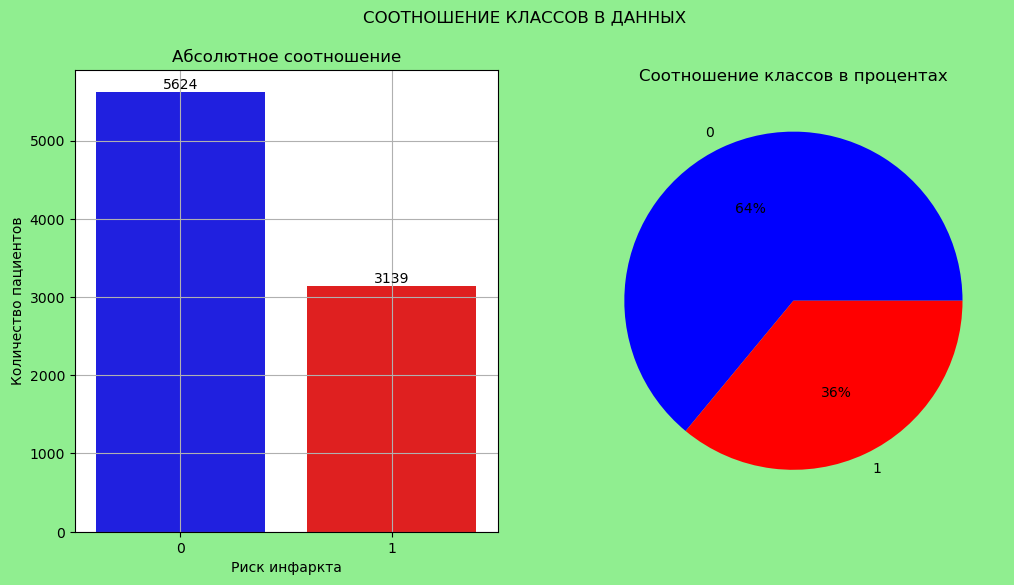

In [41]:
# Создаем датафрейм с посчитанным количеством значений в каждом классе
classes = data['Heart Attack Risk'].value_counts().reset_index()
# Создаем признак соотношения в процентах
classes['percent'] = round(classes['count'] / classes['count'].sum() * 100)
display(classes)
print(f"Разница в количестве значений между классами: {classes['count'][0] - classes['count'][1]}")

# Напишем функцию для визуализации сбалансированности классов
def balance_plot(df):
    """Функция отрисовывает график баланса классов

    Args:
        df (DataFrame): Функция принимает в качестве аргумента датафрейм 
        с количеством значений в каждом классе
    """
        # Пространство для графиков 1х2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), facecolor='lightgreen')
    # Общее название
    plt.suptitle('Соотношение классов в данных'.upper())
    # Абсолютное соотношение
    bar = sns.barplot(df,
             x='Heart Attack Risk',
             y='count',
             palette=['Red', 'Blue'][::-1],
             ax=axes[0])
    bar.bar_label(bar.containers[0])
    bar.set_title('Абсолютное соотношение')
    bar.set_xlabel('Риск инфаркта')
    bar.set_ylabel('Количество пациентов')
    bar.grid()
    # Соотношение в процентах
    plt.pie(df['percent'], labels=df['Heart Attack Risk'], colors = ['Blue', 'Red'], autopct='%.0f%%')
    plt.title('Соотношение классов в процентах')
    plt.show()
    
# Вызываем функцию
balance_plot(classes)

В задаче классификации данные называются несбалансированными, если в обучающей выборке доли объектов разных классов существенно различаются. В даннос случае дисбаланс классов составляет 28 % или 2485 единиц. 

Причина дисбаланса классов может скрываться в особенностях имеющихся данных. Выборка ключает в себя информацию о пациентах клиник, у которых был выявлен риск инфаркта. Количество таких пациентов может быть объективно меньше, чем доля пациентов без риска инфаркта.

Однако, на дисбаланс классов могут влиять дубликаты в данных. Проведем проверку на дубликаты.

In [42]:
mask = data.duplicated(subset=data.columns)
data_duplicates = data[mask]
print(f'Число найденных дубликатов: {data_duplicates.shape[0]}')

Число найденных дубликатов: 0


Дисбаланс классов связан с особенностями данных.

### 2.2. Распределение данных в числовых непрерывных призанаках

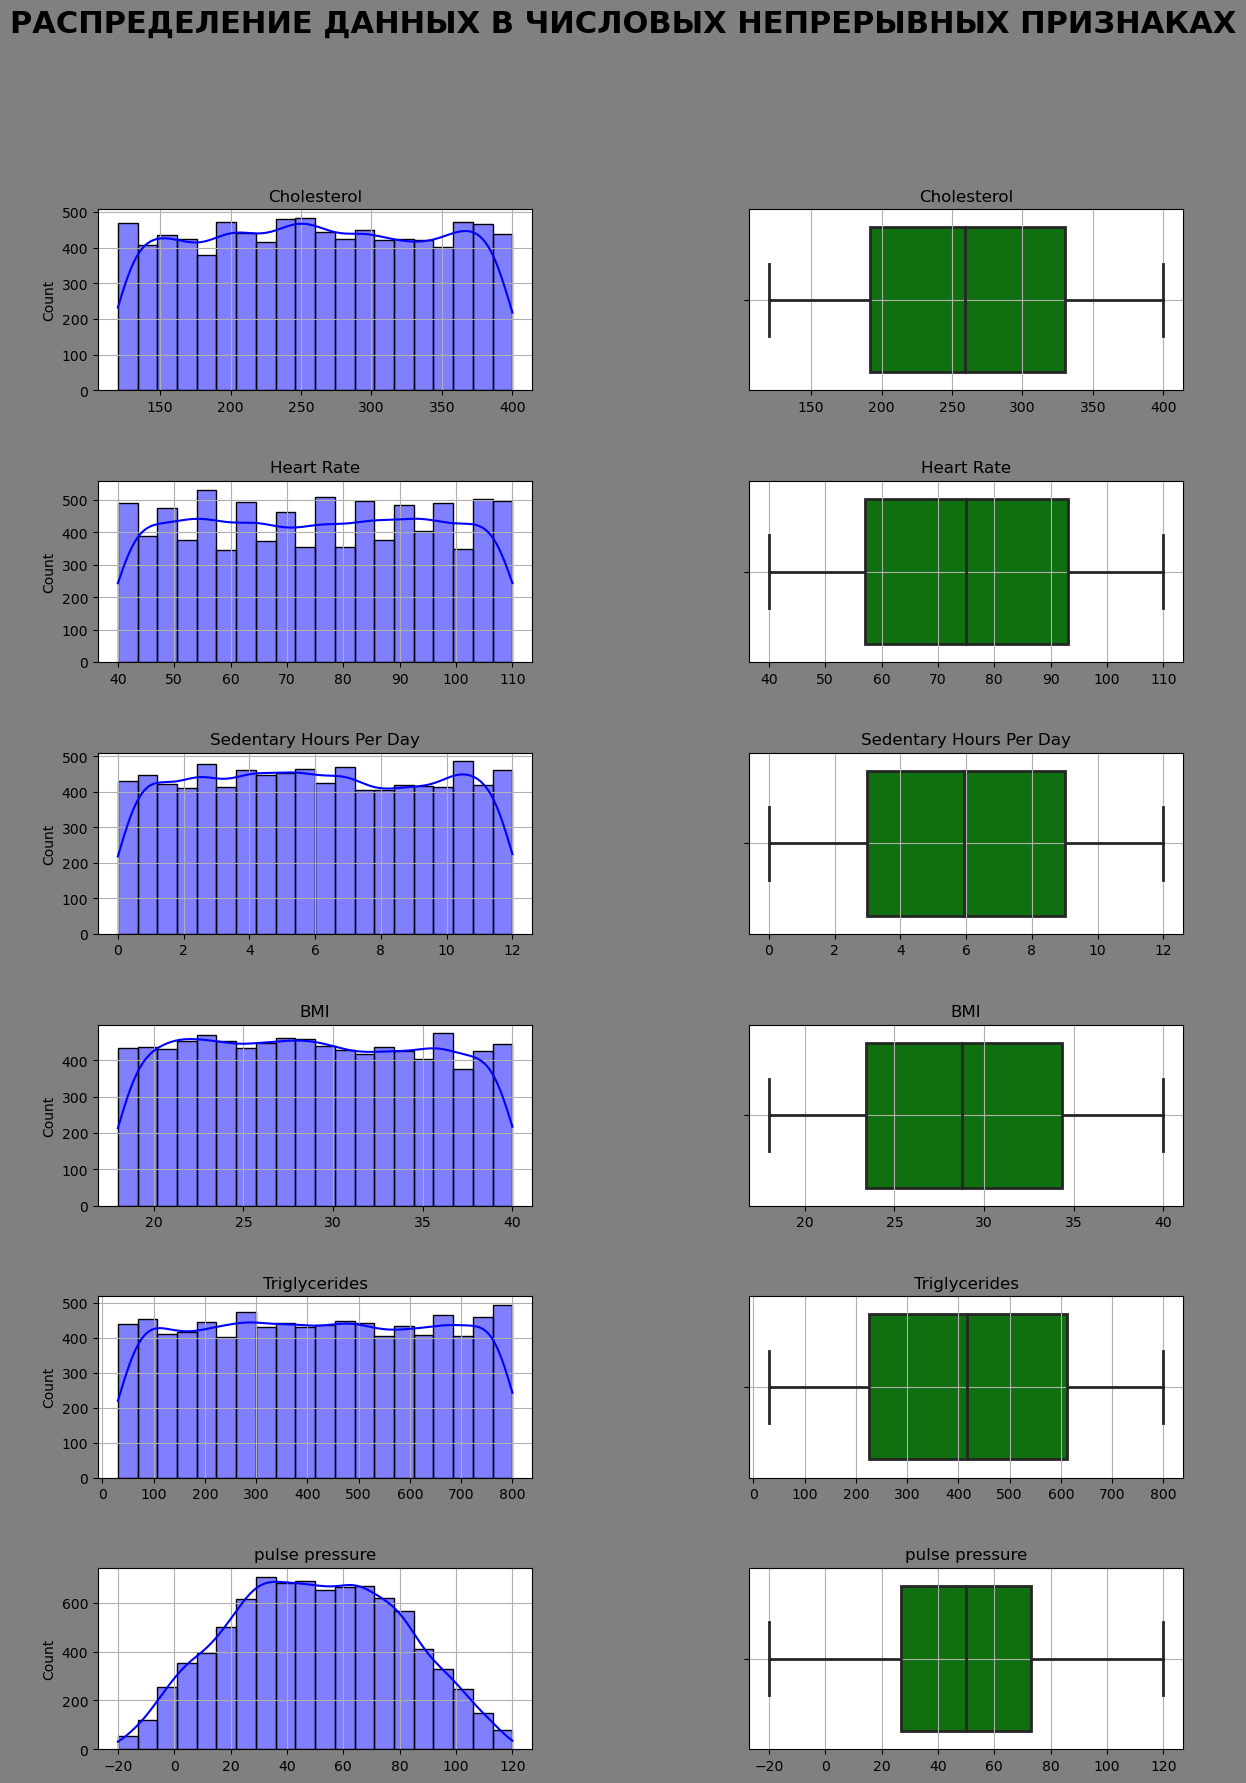

In [43]:
# Список категориальных признаков
cat_features = ['Diabetes', 'Family History', 'Smoking', 'Obesity',
               'Alcohol Consumption', 'Previous Heart Problems',
               'Medication Use', 'Stress Level', 'Physical Activity Days Per Week',
               'Sleep Hours Per Day', 'Heart Attack Risk']
# Создаем список признаков с числовыми типами данных
features = [x for x in data.columns if data[x].dtype != 'object']
# Удаляем из списка категоральные признаки
for i in cat_features:
    if i in features:
        features.remove(i)
# Длина списка
n = len(features)

# Поле для графика из n строк и 2 столбцов
fig, axes = plt.subplots(n, 2,
                         figsize=(14, 20),
                         facecolor='gray')
# Общее название графика
plt.suptitle('Распределение данных в числовых непрерывных признаках'.upper(),
            fontsize=22,
            fontweight='bold')
# Рассояние между субграфиками
plt.subplots_adjust(wspace=0.5,
                    hspace=0.5)
# Строим графики
for index, col in enumerate(features):
    # Гистограмма
    hist = sns.histplot(data,
                       x=col,
                       bins=20,
                       color='blue',
                       kde=True,
                       ax=axes[index][0])
    hist.set_title(col)
    hist.set_xlabel('')
    hist.grid()
    # Столбчатая диаграмма
    box = sns.boxplot(data,
                     x=col,
                     color='green',
                     linewidth=2,
                     ax=axes[index][1])
    box.set_title(col)
    box.set_xlabel('')
    box.grid()

Дополнительно проверим данные в признаках на нормальность распределения с помощью тест Д'Агостино $K^2$.

Тест Д’Агостино $K^2$ вычисляет эксцесс и перекос по данным, чтобы определить, отклоняется ли распределение данных от нормального распределения.

Перекос — это количественная оценка того, насколько распределение смещено влево или вправо, мера асимметрии в распределении.

Эксцесс количественно определяет, какая часть распределения находится в хвосте. 

In [44]:
# Определяем гипотезы
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'
# Устанавливаем значимость теста 0.05, т.е. допускаем ошибку с вероятностью 5%
alpha = 0.05
# Проверяем признаки на нормальность распределения
for col in features:
    # p_value - вероятность обнаружения наблюдаемых результатов,
    # когда нулевая гипотеза верна
    statistic, p = normaltest(data[col])
    print(f"p_value в признаке {col} = {p}")    
    # Интерпретация теста
    if p > alpha:
        print(H0)
    else:
        print(Ha)
    print()


p_value в признаке Cholesterol = 0.0
Данные не распределены нормально (мы отвергаем H0)

p_value в признаке Heart Rate = 0.0
Данные не распределены нормально (мы отвергаем H0)

p_value в признаке Sedentary Hours Per Day = 0.0
Данные не распределены нормально (мы отвергаем H0)

p_value в признаке BMI = 0.0
Данные не распределены нормально (мы отвергаем H0)

p_value в признаке Triglycerides = 0.0
Данные не распределены нормально (мы отвергаем H0)

p_value в признаке pulse pressure = 6.318744985193427e-130
Данные не распределены нормально (мы отвергаем H0)



In [45]:
data[features].describe().T

count        mean         std         min  \
Cholesterol              8763.0  259.877211   80.863276  120.000000   
Heart Rate               8763.0   75.021682   20.550948   40.000000   
Sedentary Hours Per Day  8763.0    5.993690    3.466359    0.001263   
BMI                      8763.0   28.891446    6.319181   18.002337   
Triglycerides            8763.0  417.677051  223.748137   30.000000   
pulse pressure           8763.0   49.919548   29.990119  -20.000000   

                                25%         50%         75%         max  
Cholesterol              192.000000  259.000000  330.000000  400.000000  
Heart Rate                57.000000   75.000000   93.000000  110.000000  
Sedentary Hours Per Day    2.998794    5.933622    9.019124   11.999313  
BMI                       23.422985   28.768999   34.324594   39.997211  
Triglycerides            225.500000  417.000000  612.000000  800.000000  
pulse pressure            27.000000   50.000000   73.000000  120.000000

**Признак "Cholesterol"**

[Холестерол общий (холестерин)](https://helix.ru/kb/item/06-048) – жироподобное вещество, необходимое организму для нормального функционирования клеток, переваривания пищи, создания многих гормонов. При избытке холестерола (холестерина) увеличивается риск появления бляшек в артериях, которые могут приводить к их закупорке и вызывать инфаркт или инсульт.

В США холестерин измеряется в миллиграммах на децилитр, в России и в Европе – в миллимолях на литр. Пересчет осуществляется по формуле: $ХС (мг/дл) = ХС (ммоль/л) × 88,5$ или $ХС (ммоль/л) = ХС (мг/дл) х 0,0113.$

[Показатели холестерина в выборке](https://en.wikipedia.org/wiki/Cholesterol) находятся в диапазоне от 120 до 400 (мг/дл). Медианное и среднее значения примерно совпадают на отметке 259. Для сердечных заболеваний низкий уровень вероятности при холестерине меньшем 200 мг/дл. Под это значение попадают 25-30 % пациентов в выборке. 200-240 мг/дл - пограничный риск. Эта категория также находится до среднего и медианного значения. Больше 240 мг/дл - высокий риск. Более 50% пациентов в выборке находятся в этой группе.

**Признак "Heart Rate"**

[Частота сердечных сокращений (ЧСС),](https://center-light.ru/article/295) которую мы привыкли рассматривать как один из главных показателей деятельности сердечно-сосудистой системы, в действительности имеет гораздо более широкое значение. Чем выше ЧСС, тем выше в организме человека скорость протекания обменных процессов, тем выше и уровень энергетической потребности. 

Нормальная частота сердечных сокращений для взрослых в возрасте старше 10 лет, включая пожилых людей, составляет от 60 до 90 ударов в минуту. ЧСС может увеличиваться на короткое время в ответ на физические упражнения, температуру тела, эмоциональные триггеры и положение тела (быстрое вставание с постели).

[Pезультаты клинических исследований доказали,](https://htn.almazovcentre.ru/jour/article/view/1250?locale=ru_RU#:~:text=%D0%90%D0%BD%D0%BD%D0%BE%D1%82%D0%B0%D1%86%D0%B8%D1%8F,%D1%81%D0%B5%D1%80%D0%B4%D0%B5%D1%87%D0%BD%D0%BE%2D%D1%81%D0%BE%D1%81%D1%83%D0%B4%D0%B8%D1%81%D1%82%D0%BE%D0%B9%20%D0%B7%D0%B0%D0%B1%D0%BE%D0%BB%D0%B5%D0%B2%D0%B0%D0%B5%D0%BC%D0%BE%D1%81%D1%82%D0%B8%20%D0%B8%20%D1%81%D0%BC%D0%B5%D1%80%D1%82%D0%BD%D0%BE%D1%81%D1%82%D0%B8.) что частота сердечных сокращений более 80-85 ударов/минуту в состоянии покоя непосредственно связана с риском развития артериальной гипертензии и атеросклероза и является значимым предиктором сердечно-сосудистой заболеваемости и смертности.

В представленной выборке разброс значений ЧСС от 40 до 110 ударов в минуту. Пониженный уровень пульса в состоянии покоя отмечается у 25% пациентов. Пациенту, которые находятся в границах нормального пульса до риска седечно сосудистых заболеваний (60-80 ударов в минуту) находятся в пределах примерно 27-60 %. Первые две категории немногим превышают среднее значение по выборке. Примерно 40% пациентов находятся в зоне риска.

**Признак "Sedentary Hours Per Day"**

[Результаты медицинских исследований 2020 года подтвердили,](https://www.ecomeds.ru/news_55.htm) что сидячий образ жизни увеличивает риск смертости от сердечно-сосудистых заболеваний на 34%, по сравнению с теми, кто ведет активный образ жизни.

Минимальный уровень сидячего образа жизни (до 3 часов в день) у 25% пациентов в выборке. Медианное значение на уровне 6 часов, что примерно соответствует полному рабочему дню. Примерно у половины человек сидячий образ жизни занимает от 6 до 12 часов в день.

**Признак "BMI"**

[Индекс массы тела](https://cgon.rospotrebnadzor.ru/naseleniyu/zdorovyy-obraz-zhizni/chto-takoe-indeks-massy-tela/) - показатель физического развития человека, оценивающий соотношение роста и массы тела. Чем выше ИМТ – тем выше риск развития сердечно-сосудистых заболеваний, гипертонии, остеоартрита, диабета, некоторых видов рака. Дефицит массы тела также значительно повышает риск преждевременной смерти. Таким образом ИМТ помогает точнее оценить риски для здоровья, связанные с весом.

Однако ИМТ не является самым точным показателем, т.к. не показывает реального соотношения жира и мышц в человеческом теле. Его используют исключительно для ориентировочной оценки, т.к. попытка оценить с его помощью телосложение профессиональных спортсменов может дать неверный результат (высокое значение индекса в этом случае объясняется развитой мускулатурой). Еще одним недостатком метода служит отсутствие дифференциации по полу и возрасту, средние нормальные значения соотношения веса и роста в различных культурах и странах могут существенно отличаться. ИМТ не учитывает особенности распределения жира в организме. В ряде случаев это имеет существенное значение, потому что ожирение «по типу яблока» (когда жировая ткань откладывается преимущественно в области живота) прогностически значимо хуже ожирения «по типу груши» (когда жировая ткань откладывается преимущественно на бедрах). В первом случае риск развития диабета 2 типа сердечно-сосудистых заболеваний существенно выше.


В соответствии с рекомендациями ВОЗ результаты интерпретируют следующим образом:
+ 16 и менее - выраженный дефицит массы тела.
+ 16…18,5 - недостаточная (дефицит) масса тела.
+ 18,5…25 - нормальная масса тела.
+ 25…30 - избыточная масса тела (предожирение).
+ 30…35 - ожирение 1 степени.
+ 35…40 - ожирение 2 степени.
+ 40 и более - ожирение 3 степени.

В выборке BMI распределен от 18 до 39.9. У незначительного числа пациентов наблюдается дефицит массы тела. Нормальная масса тела у 25-27% пациентов. Ожирение примерно у 40% пациентов в выборке.

**Признак "Triglycerides"**

[Триглицериды](https://gemotest.ru/info/spravochnik/analizy/triglitseridy/) — основной источник энергии для организма. Они запасаются в виде жира и расходуются в перерывах между приёмами пищи. Также триглицериды выполняют термозащитную функцию (сохраняют тепло) и защищают внутренние органы от механических повреждений. Если обмен триглицеридов нарушается, то в организме накапливается слишком много жировой ткани. Развивается ожирение.

+ [Нормальный уровень триглицеридов](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/in-depth/triglycerides/art-20048186#:~:text=Triglycerides%20are%20a%20type%20of,stored%20in%20your%20fat%20cells.) у женщин и мужчин старше 18 лет 0,2–1,7 ммоль/л (меньше 150 мг/дл)
+ Умеренно повышенный 1,70–2,25 (150-199 мг/дл)
+ Повышенный 2,26–5,65 (200-499 мг/дл)
+ Высокий уровень > 5,65 (больше 500 мг/дл)

Уровень триглициридов в выборке находится в диапазоне от 30 до 800 мг/дл. Нормальный уровень менее чем у 25% пациентов. Медианное значение находтся в пределах повышенного уровня - 417 мг/дл. Более 70% имеют высокий уровень триглициридов.

**Признак "pulse pressure"**

[Пульсовое давление](https://24health.by/chto-takoe-pulsovoe-davlenie-norma-otkloneniya/) косвенно может свидетельствовать о том, в каком состоянии находятся сердечная мышца и клапаны сердца. 

Очень маленькая разница между верхним и нижним давлением может свидетельствовать о снижении сократительной способности сердца и развитии хронической сердечной недостаточности, которая является исходом многих сердечно-сосудистых заболеваний, отмечает специалист.

Низким считается пульсовое давление менее 30 мм рт. ст.

Такая ситуация может быть как при сильном переутомлении, так и являться признаком таких патологий, как:
+ миокардит;
+ инфаркт миокарда;
+ выраженная тахикардия;
+ стеноз устья аорты;
+ сердечная недостаточность;
+ кардиосклероз (болезнь, при которой ткань миокарда замещается соединительной тканью).

Частой причиной высокого пульсового давления является психоэмоциональный стресс.

Нередко к повышению пульсового давления приводит повышенная жесткость крупных артерий, что наблюдается при выраженном атеросклерозе. Причем, чем выше пульсовое давление, тем сосуды жестче и тем сильнее они поражены атеросклеротическими бляшками.

Одной из причин высокого пульсового давления может быть значимая недостаточность аортального клапана.

Кроме того, к факторам, которые могут привести к высокому пульсовому давлению, относятся дефицит железа в организме (анемия) и нарушения в работе щитовидной железы (гипертиреоз).

В выборке пульсовое давление находится в диапазоне от -20 до 120. Низкие показатели наблюдаютсяпримерно у 30% пациентов.

### 2.3. Распределение данных в категориальных признаках

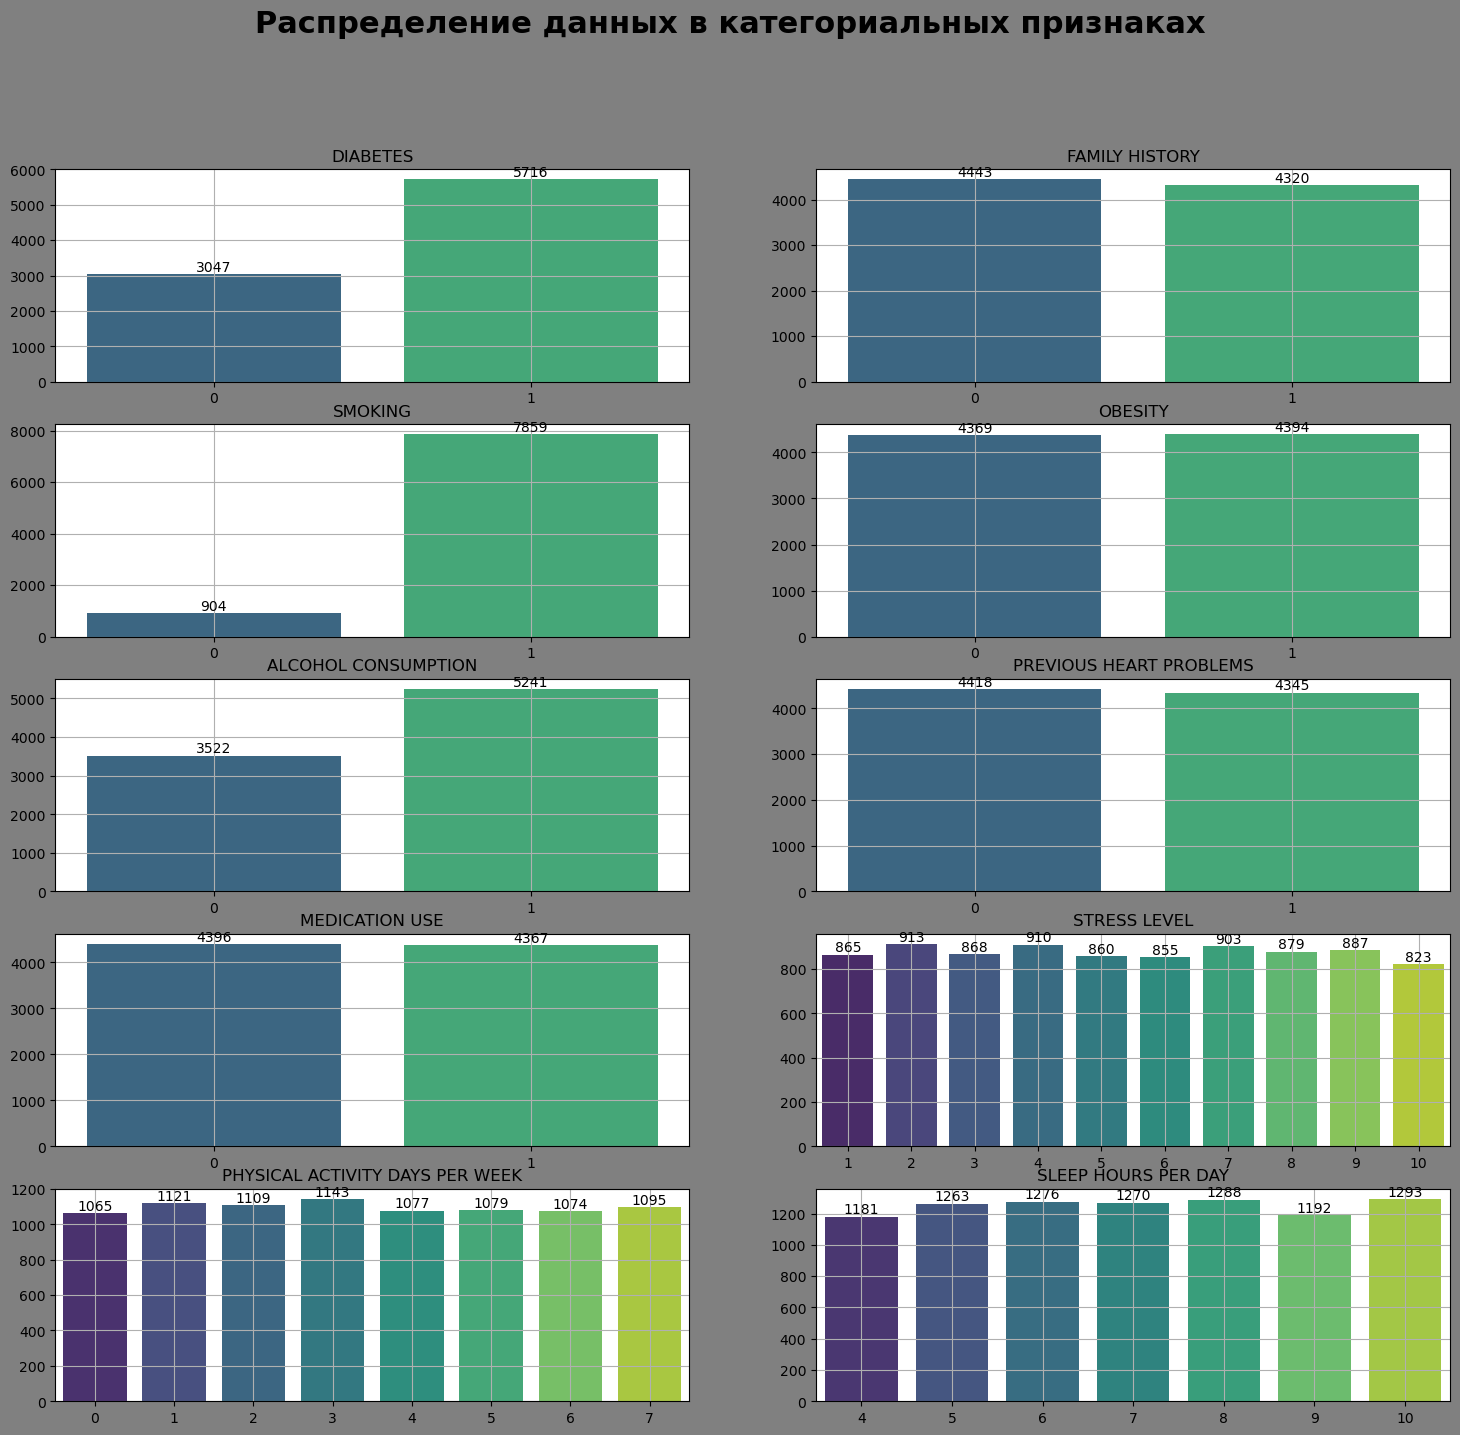

In [46]:
# Удаляем таргет из списка категориальных признаков
cat_features.remove('Heart Attack Risk')

# Создаем поле для графиков на 5 строк и 2 колонки
fig, axes = plt.subplots(5, 2,
                         figsize=(18, 16),
                         facecolor='gray')
# Пространство между субграфисками
plt.subplots_adjust(hspace=0.2,
                    wspace=0.2)
# Общее название 
plt.suptitle('Распределение данных в категориальных признаках',
             fontsize=22,
             fontweight='bold')

# Строим столбчатую диаграмму для каждого признака
for col, ax in zip(cat_features, axes.ravel()):
    barplot = sns.barplot(data,
                            x=data[col].value_counts().index,
                            y=data[col].value_counts().values,
                            palette='viridis',
                            ax=ax)
    barplot.set_title(col.upper())
    barplot.set_xlabel('')
    ax.bar_label(ax.containers[0])
    ax.grid()

In [47]:
display(data[cat_features].describe().T)

for i in cat_features:
    print(f'Процентное соотношение данных в признаке: {round(data[i].value_counts(normalize=True)*100)}')
    print()

count      mean       std  min  25%  50%  \
Diabetes                         8763.0  0.652288  0.476271  0.0  0.0  1.0   
Family History                   8763.0  0.492982  0.499979  0.0  0.0  0.0   
Smoking                          8763.0  0.896839  0.304186  0.0  1.0  1.0   
Obesity                          8763.0  0.501426  0.500026  0.0  0.0  1.0   
Alcohol Consumption              8763.0  0.598083  0.490313  0.0  0.0  1.0   
Previous Heart Problems          8763.0  0.495835  0.500011  0.0  0.0  0.0   
Medication Use                   8763.0  0.498345  0.500026  0.0  0.0  0.0   
Stress Level                     8763.0  5.469702  2.859622  1.0  3.0  5.0   
Physical Activity Days Per Week  8763.0  3.489672  2.282687  0.0  2.0  3.0   
Sleep Hours Per Day              8763.0  7.023508  1.988473  4.0  5.0  7.0   

                                 75%   max  
Diabetes                         1.0   1.0  
Family History                   1.0   1.0  
Smoking                          1.0   1.0  
Obesity                          1.0   1.0  
Alcohol Consumption              1.0   1.0  
Previous Heart Problems          1.0   1.0  
Medication Use                   1.0   1.0  
Stress Level                     8.0  10.0  
Physical Activity Days Per Week  5.0   7.0  
Sleep Hours Per Day              9.0  10.0

Процентное соотношение данных в признаке: Diabetes
1    65.0
0    35.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Family History
0    51.0
1    49.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Smoking
1    90.0
0    10.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Obesity
1    50.0
0    50.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Alcohol Consumption
1    60.0
0    40.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Previous Heart Problems
0    50.0
1    50.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Medication Use
0    50.0
1    50.0
Name: proportion, dtype: float64

Процентное соотношение данных в признаке: Stress Level
2     10.0
4     10.0
7     10.0
9     10.0
8     10.0
3     10.0
1     10.0
5     10.0
6     10.0
10     9.0
Name: proportion, dtype: float64

Процентное соотношение данных 

**Признак "Diabetes"**

[Сахарный диабет](http://old.xn--62-6kct0akqt0e.xn--p1ai/novosti/saharnyj-diabet-i-serdecno-sosudistye-zabolevania-problemy-mirovogo-masstaba) представляет собой тяжелое прогрессирующее и чрезвычайно распространенное заболевание, связанное с развитием многочисленных осложнений, если его не лечить и не контролировать.Люди, страдающие сахарным диабетом в сочетании с избыточной массой или ожирением, с постоянным повышением уровня глюкозы, курением, допускающие погрешности в диете, с повышенным АД, повышенным уровнем холестерина крови подвержены более высокому риску возникновения сердечно-сосудистых осложнений.

Вероятность развития инфаркта миокарда при сахарном диабете повышена в 6 раз, а риск развития инсульта в 3 раза. У более 50% пациентов на момент обнаружения сахарного диабета уже имеют диагноз: Ишемическая болезнь сердца (ИБС). Течение ИБС зависит от длительности сахарного диабета. ИБС во многих случаях протекает бессимптомно. У пациентов с сахарным диабетом высокая частота безболевых («немых») форм ИБС и инфаркта миокарда (до 60% инфаркт миокарда при сахарном диабете протекает именно так).

В признаке данные подчиняются распределению Бернулли (0, 1). 65% (5716) пациентов в выборке имеют заболевание сахарным диабетом.

**Признак "Family History"**

[Семейный анамнез (история болезни)](https://cardianmed.by/informacziya/stati/faktoryi-riska-ibs.html) ранней стадии болезни сердца также является фактором риска, включая обнаружение болезни сердца у отца или брата в возрасте до 55 лет, а у матери или сестры – в возрасте до 65 лет.

В признзнаке данные имеют два исхода (0, 1) и имеют примерно одинаковое соотношение в долях. У 51% пациентов нет семейной истории заболеваний и у 49% она есть.

**Признак "Smoking"**

[Курение и сердечно-сосудистые заболевания тесно связаны](http://hospkuz.ru/index.php/materialy/kurenie-i-bolezni-serdtsa). Кислородное голодание, наступающее вследствие вдыхания табачного дыма, негативно отражается на всей сердечно-сосудистой системе. Вред курения для сердца состоит в создании условий для нарушения кровоснабжения — атеросклероза. Влияние курения на сердце заключается в увеличении вязкости крови и повышении риска тромбообразования. Табачный дым влияет на распределение липидов крови в пользу так называемого «вредного холестерина», который активно откладывается на стенках сосудов в виде холестериновых бляшек. Отложения холестерина приводят к сужению просвета сосудов. Это все приводит к ишемии — недостатку кислорода в сердечной мышце. У курильщиков с большим стажем высокая вероятность перекрытия просвета коронарной артерии, питающей сердечную мышцу, тромбом или холестериновой бляшкой. Это приводит к стенокардии или инфаркту миокарда.

В выборке 7859 (90%) пациентов курят и только 904 (10%) не курят.

**Признак "Obesity"**

[Ожирение](https://fitness-pro.ru/biblioteka/ozhirenie-i-serdechno-sosudistye-zabolevaniya-faktory-riska-i-paradoks-ozhireniya/) влияет на объем крови, который проходит через сердце. Больший объем крови сильнее давит на стенки сосудов кровеносной системы, то есть организм вынужден приспосабливаться к большим нагрузкам. По мере повышения объемов и давления при заполнении кровью отделов сердца у людей с избыточным весом и с ожирением нередко увеличивается камера левого желудочка. Причем риск гипертрофии (увеличения) левого желудочка (ГЛЖ) возрастает независимо от возраста и артериального давления. Повышается вероятность изменений структуры сердца: концентрического ремоделирования миокарда и левого желудочка. Под ремоделированием понимают целый комплекс изменений, происходящих в сердце: утолщение стенок и самих мышечных волокон, увеличение количества компонентов сердечных поперечно-полосатых мышц и т.п.

В признаке данные рапределены равномерно по 50% пациентов с ожирением и без него.

**Признак "Alcohol Consumption"**

Призанк показывает, употребляет ли пациент алкоголь. 60% пациентов в выборке употребляют, 40% - нет.

**Previous Heart Problems**

В признаке отмечены предыдущие проблемы с сердцем у пациента. Данные распределены по 50%


### 2.4. Признаки "Country" и "Continent"

Исследуем из каких стран представлены данные, а также как риск инфаркта рапространяется в зависимости от континента и страны.

In [48]:
# Сгруппируем данные по сонтиненту и стране
country = data.groupby(by=['Continent', 'Country'],
                      as_index=False)['Heart Attack Risk'].value_counts()
display(country['Country'].unique())

# Посмотрим на графике, какие страны представлены в данных
fig = px.choropleth(country,
                   locations='Country',
                   locationmode='country names',
                   color='Heart Attack Risk',
                   color_continuous_scale='Reds',
                   title='Страны, представленные в выборке',
                   height=600,
                   width=800)

fig.show()

array(['Nigeria', 'South Africa', 'China', 'India', 'Japan',
       'South Korea', 'Thailand', 'Vietnam', 'Australia', 'New Zealand',
       'France', 'Germany', 'Italy', 'Spain', 'United Kingdom', 'Canada',
       'United States', 'Argentina', 'Brazil', 'Colombia'], dtype=object)

Посмотрим как распределяются значения риска инфаркта по континентам и странам

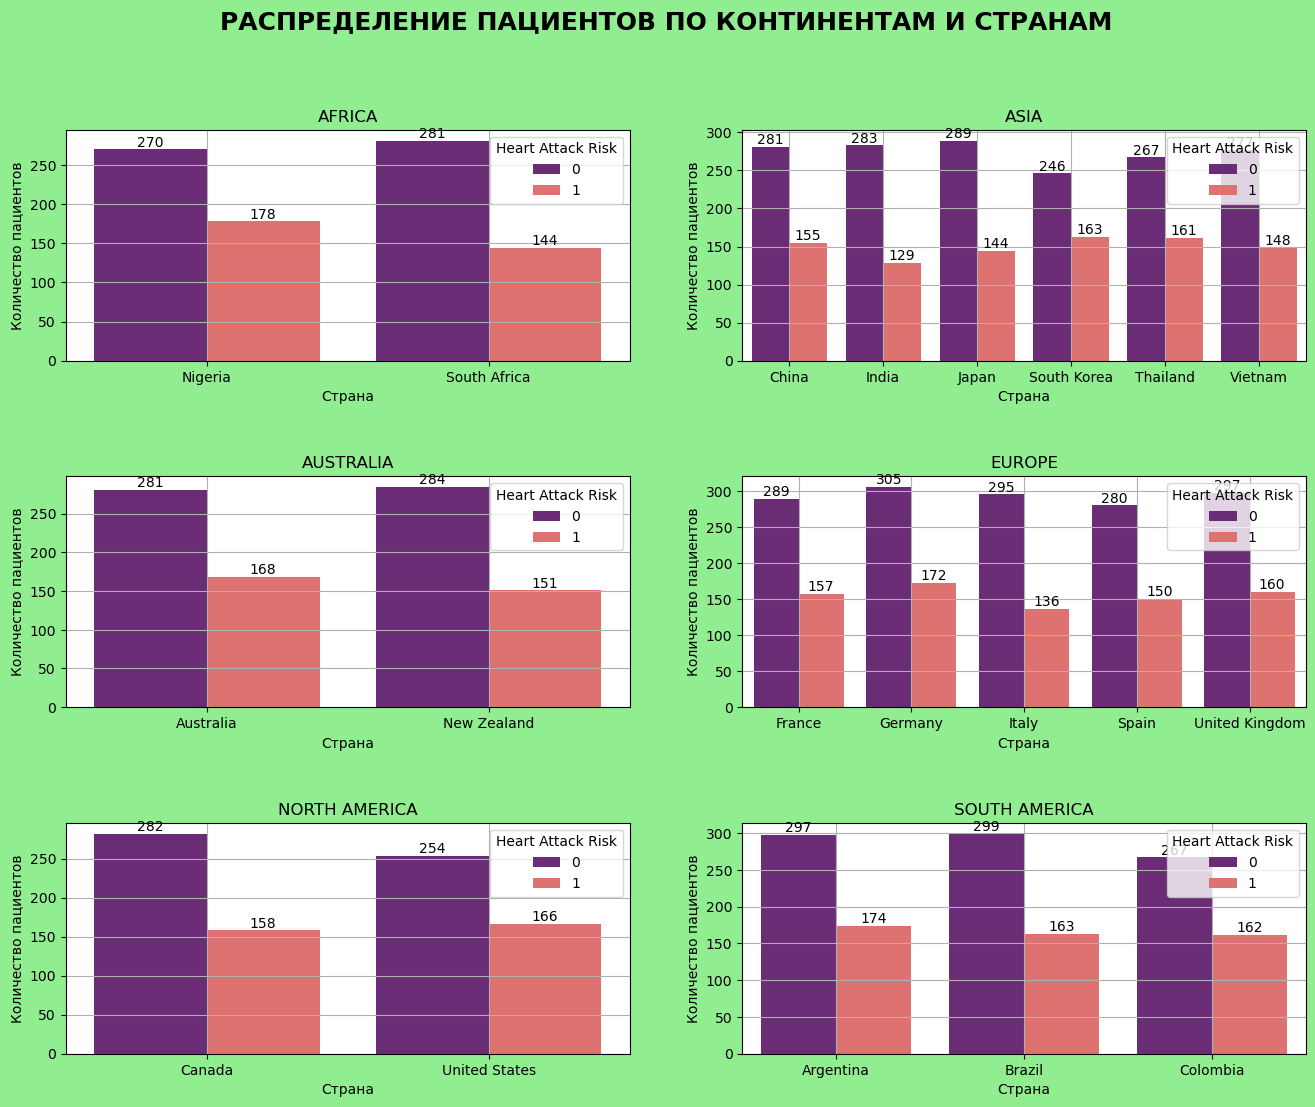

In [74]:
# Пространство для графиков 1х2
fig, axes = plt.subplots(3, 2, figsize=(16, 12), facecolor='lightgreen')
# Общее название
plt.suptitle('Распределение пациентов по континентам и странам'.upper(),
             fontsize=18,
             fontweight='bold')
# Пространство между субграфисками
plt.subplots_adjust(hspace=0.5, wspace=0.2)
# Проходим циклом по уникальным значениям в признаке континента
for continent, ax in zip(country['Continent'].unique(), axes.ravel()):
    # Для каждого континента строим barplot
    bar = sns.barplot(country[country['Continent'] == continent],
                      x='Country',
                      y='count',
                      hue='Heart Attack Risk',
                      palette='magma',
                      ax=ax)
    bar.set_title(continent.upper())
    bar.set_xlabel('Страна')
    bar.set_ylabel('Количество пациентов')
    bar.bar_label(bar.containers[0])
    bar.bar_label(bar.containers[1])
    ax.grid()

На Африканском континенте данные собирались в двух странах Нигерии (448 пациентов) и ЮАР (425 пациентов). Соотношение по риску инфаркта в этих странах примерно одинаковое. В Нигерри подвержены риску 178 человек, а в ЮАР - 144. Возможно, такие показатели связаные с низким уровнем исследований в жтих странах.

Из Азиатских стран в выборке представлены шесть: Китай, Индия, Япония, Южная Корея, Тайланд, Вьетнам. Количество пациентов примерно одинаковые. Представленные страны с разным уровнем жизни и экономического развития. Наибольший риск инфаркта наблюдается у пациентов из Японии, Индии и Китая, а наименьший - из Южной Кореи.

В Австралии и Новой Зеландии также схожее количество пациентов и риск инфаркта примерно одинаков.

В выборке представлены пять европейских стран: Франция, Германия, Италия, Испания, Великобритания. Здесь самыевысокие показатели по риску инфаркта. Наибольшие в Германии, Великобритании и Италии.

В Северной Америке количество пациентов с риском инфаркта выше в Канаде, чем в США. А в Южной Америке Бразилия и Аргентина превышают по риску инфаркта Колумбию. Но это также может быть связано с уровнем медицинских исследований.

### 2.5. Признак "Physical activity group"

Исследуем влияние объема физической активности на риск инфаркта

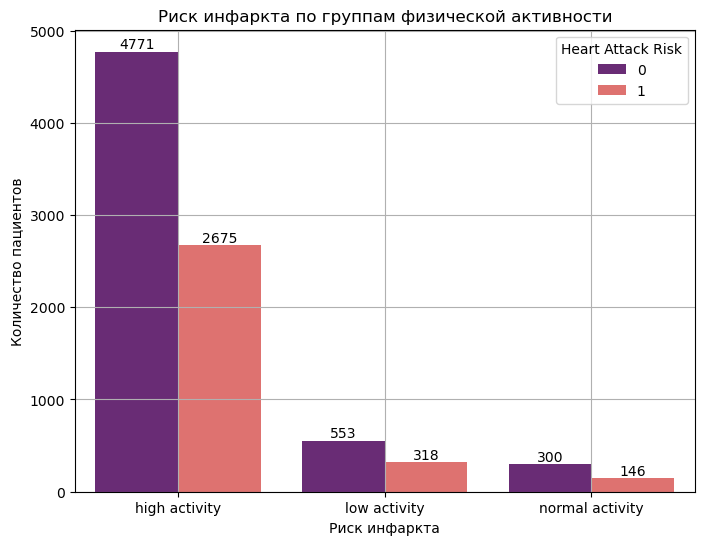

In [88]:
# Сгруппируем данные о риске инфаркта по группе физической активности
activity = data.groupby(by='Physical activity group',
                       as_index=False)['Heart Attack Risk'].value_counts()
# Представим в виде графика
plt.rcParams['figure.figsize'] = (8, 6)
bar = sns.barplot(activity,
         x='Physical activity group',        
         y='count',
         hue='Heart Attack Risk',
         palette='magma'
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Риск инфаркта по группам физической активности')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()

Большая часть пациентов в выборке относятся к группе высокой физической активности - 7446, больше половины из них находятся в группе с отсутствием риска инфаркта (4771). 871 человек в группе низкой активности (318 с риском инфаркта) и 446 в нормальной (146 с риском инфаркта). 

### 2.6. Признак "Age group"

Посмотрим как риск инфаркта распределяется по возрастным группам

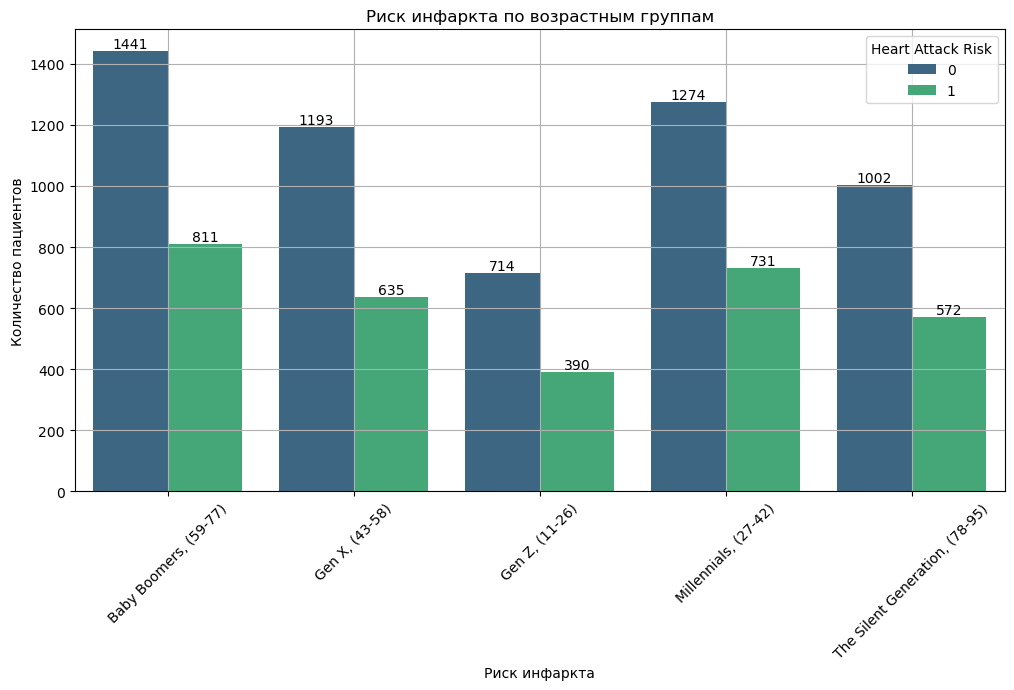

In [91]:
# Группируем данные по возрастной группе
age = data.groupby(by='Age group', as_index=False)['Heart Attack Risk'].value_counts()

# Строим график
plt.rcParams['figure.figsize'] = (12, 6)
bar = sns.barplot(age,
         x='Age group',        
         y='count',
         hue='Heart Attack Risk',
         palette='viridis'
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Риск инфаркта по возрастным группам')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()
plt.xticks(rotation=45);

Наибольший риск инфаркта в выборке наблюдается у пациентов в возрастных группах 59-77 лет и 27-42 года, а наименьший в самой младшей возрастной группе.

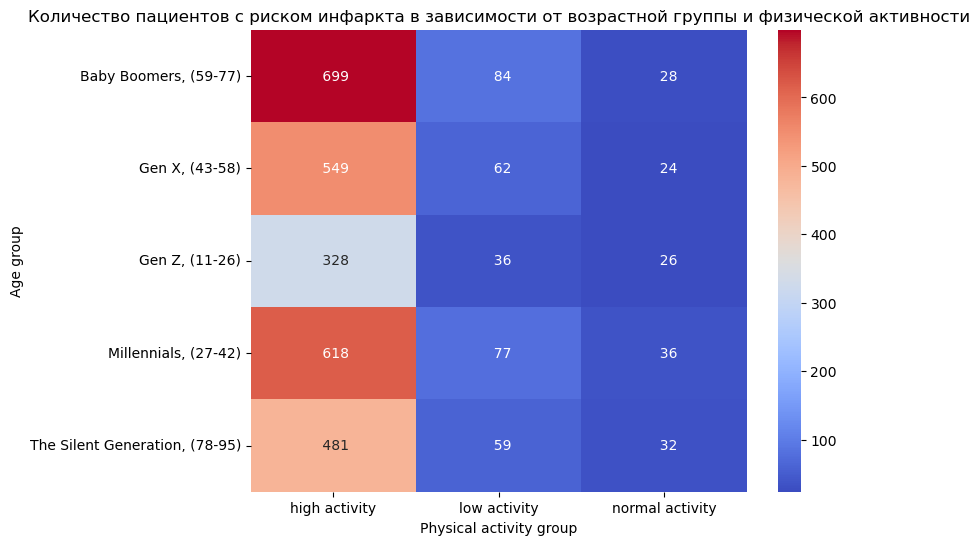

In [92]:
# Составим сводную таблцу, чтобы посмотреть как 
age_activity_groups = pd.pivot_table(data,
                                     values='Heart Attack Risk',
                                     index='Age group',
                                     columns='Physical activity group',
                                     aggfunc='sum')

# Построим тепловую карту
fig = plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(age_activity_groups, 
                      annot=True,
                      cmap='coolwarm',
                      fmt='4g')
heatmap.set_title('Количество пациентов с риском инфаркта в зависимости от возрастной группы и физической активности');

### 2.7. Признак "income group"

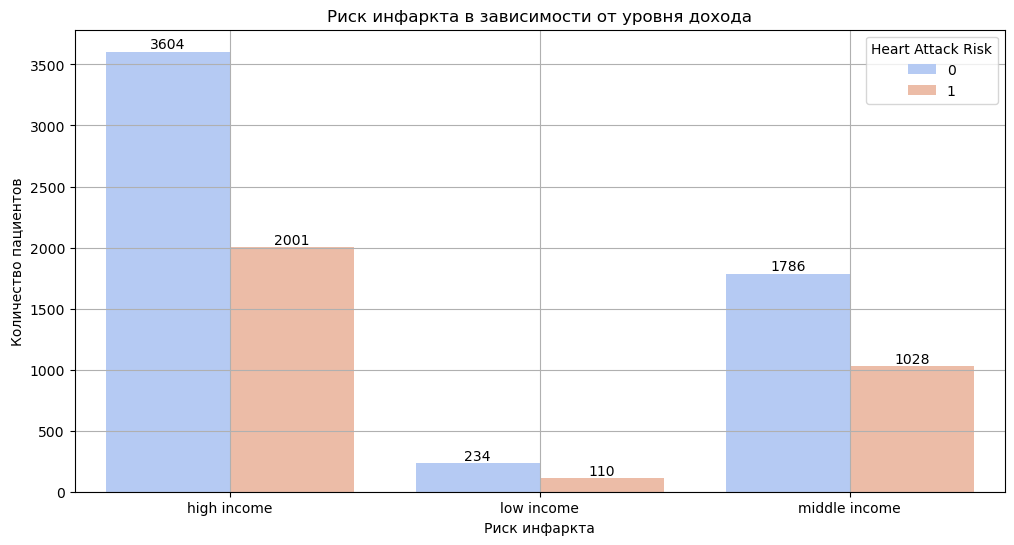

In [93]:
# Сгруппируем риск инфаркта по уровню дохода пациентов
income = data.groupby(by='income group', as_index=False)['Heart Attack Risk'].value_counts()

# Строим график
plt.rcParams['figure.figsize'] = (12, 6)
bar = sns.barplot(income,
         x='income group',        
         y='count',
         hue='Heart Attack Risk',
         palette='coolwarm'
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Риск инфаркта в зависимости от уровня дохода')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()

Большинство пациентов в выборке из группы с высоким уровнем дохода, затем со средним и в итоге с низким. Вероятно, пациенты с низким уровнем дохода реже проходят обследования и попадают в статистику. Во всех трех группах отсутствие риска инфаркта значительно превышает, его наличие.

### 2.8. Зависимости в медицинских признаках

К медицинским признакам относятся 'Cholesterol', 'Heart Rate', 'BMI', 'Triglycerides' and 'Medication Use'

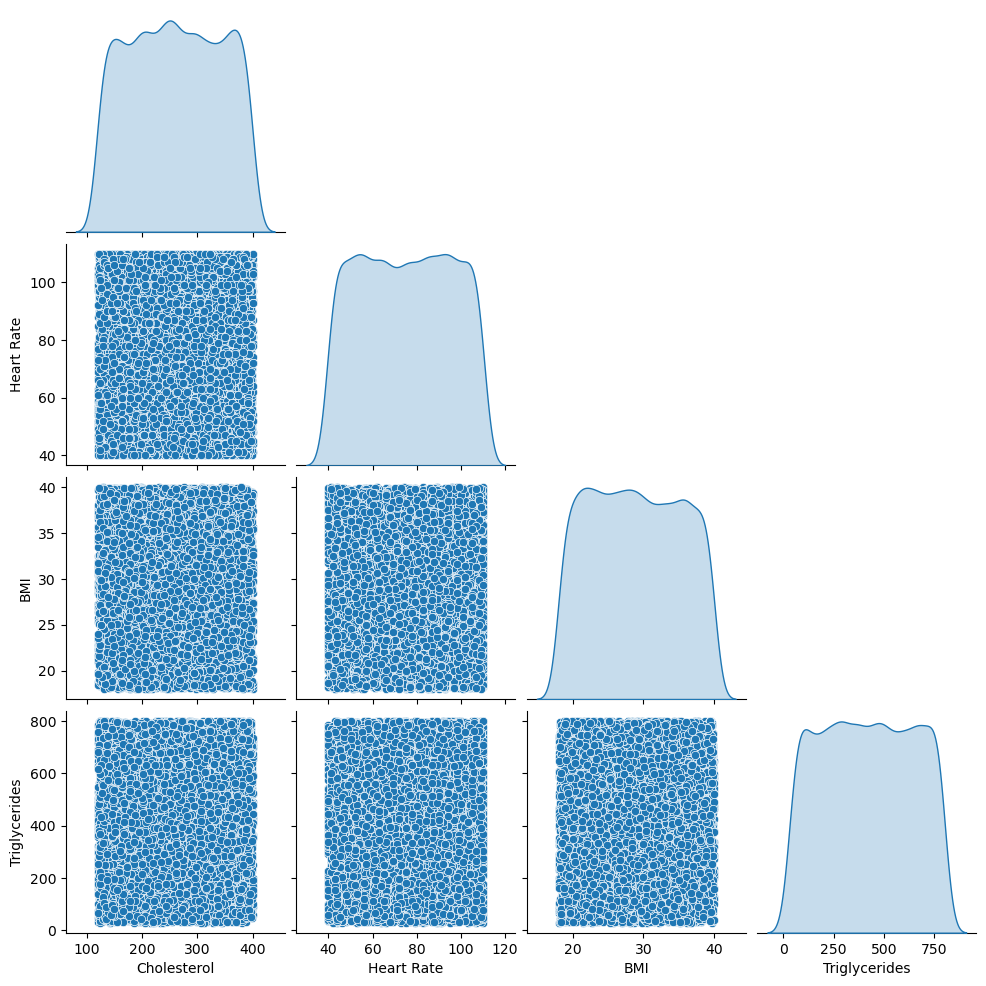

In [94]:
# Создаем Dataframe с признаками 'Cholesterol', 'Heart Rate', 'BMI', 'Triglycerides'
medical_features = data[['Cholesterol', 'Heart Rate', 'BMI', 'Triglycerides']]
# Посмотрим связи между парами признаков
pair = sns.pairplot(medical_features,
                    corner=True,
                    diag_kind='kde')

<Axes: >

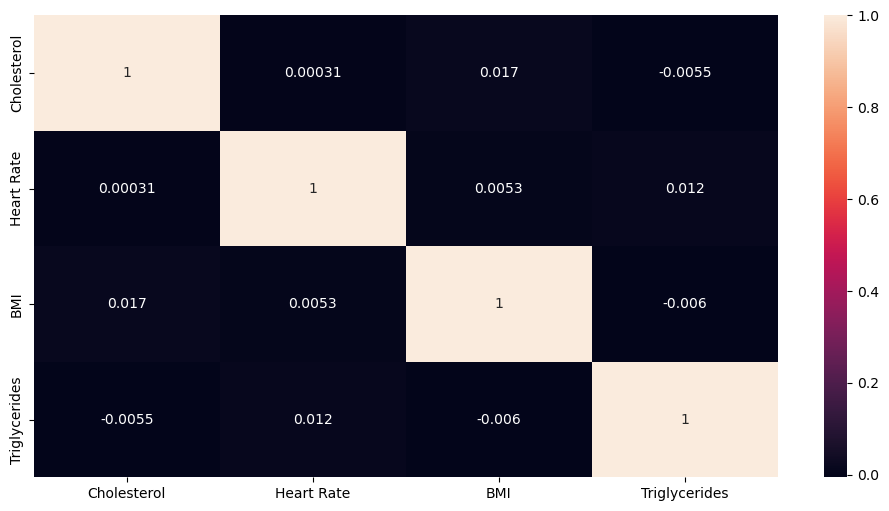

In [95]:
# Дополнительно построим матрицу корреляций
sns.heatmap(medical_features.corr(), annot=True)

Линейная зависимсость между признаками не выялена. Во всех случаях корреляция около 0.

Далее посмотрим на вероятность инфаркта в зависимости от использования медицинских препаратов.

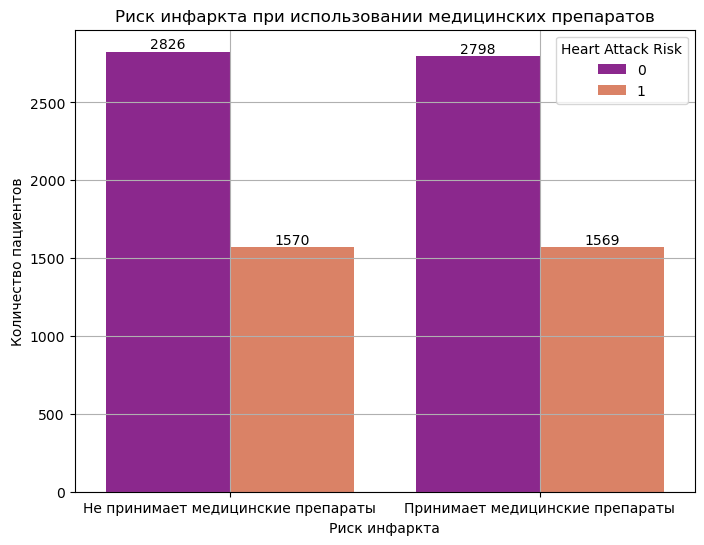

In [101]:
# Сгруппируем данные по использованию медикаментов
medication = data.groupby(by='Medication Use', as_index=False)['Heart Attack Risk'].value_counts()
# Заменим 0 и 1 текстом
medication['Medication Use'] = medication['Medication Use'].apply(lambda x: 'Принимает медицинские препараты' if x == 1 else 'Не принимает медицинские препараты')

# Педставим в вие столбчатой диаграммы
plt.rcParams['figure.figsize'] = (8, 6)
bar = sns.barplot(medication,
         x='Medication Use',        
         y='count',
         hue='Heart Attack Risk',
         palette='plasma'
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Риск инфаркта при использовании медицинских препаратов')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()

In [102]:
# Проведем тест на корреляцию
data['Heart Attack Risk'].corr(data['Medication Use'], method='spearman')

0.0022344065306511857

Данные в выборке примерно сбалансированы. Не наблюдается линейная зависимость между признаками.

Рассмотрим также наличие других сердечно-сосудистых заболеваний у пациентов и их связь с риском инфаркта.

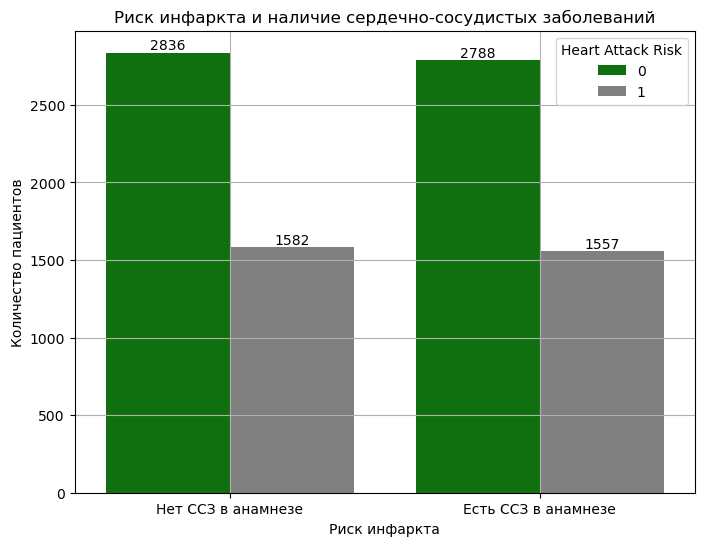

In [105]:
# Группируем данные по предыдущим проблемам с сердцем
heart_problems = data.groupby(by='Previous Heart Problems', as_index=False)['Heart Attack Risk'].value_counts()
# Заменим 0 и 1 текстом
heart_problems['Previous Heart Problems'] = heart_problems['Previous Heart Problems'].apply(lambda x: 'Есть ССЗ в анамнезе' if x == 1 else 'Нет ССЗ в анамнезе')

# Педставим в вие столбчатой диаграммы
plt.rcParams['figure.figsize'] = (8, 6)
bar = sns.barplot(heart_problems,
         x='Previous Heart Problems',        
         y='count',
         hue='Heart Attack Risk',
         palette=['green', 'grey']
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Риск инфаркта и наличие сердечно-сосудистых заболеваний')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()

In [106]:
# Проведем тест на корреляцию
data['Heart Attack Risk'].corr(data['Previous Heart Problems'], method='spearman')

0.00027356445110159457

Линейной зависимости между признаками не обнаруживается. Данные распределены примерно одинаково. У большинства пациентов в обеих группах отсутствует риск инфаркта.

### 2.9. Стиль жизни

Проанализируем связь здорового и нездорового образа жизни и риска инфаркта у пациентов в выборке

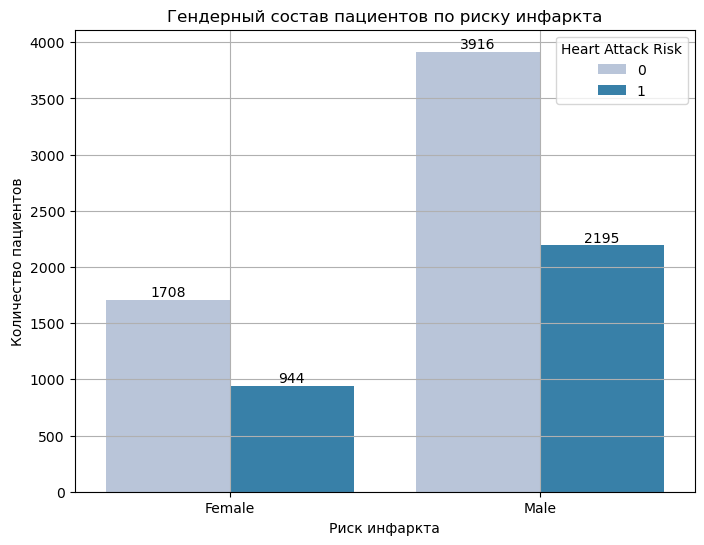

In [108]:
gender = data.groupby(by='Sex', as_index=False)['Heart Attack Risk'].value_counts()
# Педставим в вие столбчатой диаграммы
plt.rcParams['figure.figsize'] = (8, 6)
bar = sns.barplot(gender,
         x='Sex',        
         y='count',
         hue='Heart Attack Risk',
         palette='PuBu'
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Гендерный состав пациентов по риску инфаркта')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()

In [109]:
data['Heart Attack Risk'].corr(data['Sex'], method='spearman')

0.0030953177876722345

Количество мужчин в выборке значительно превышает количество женщин. Также доля риска инфаркта выше у мужчин.

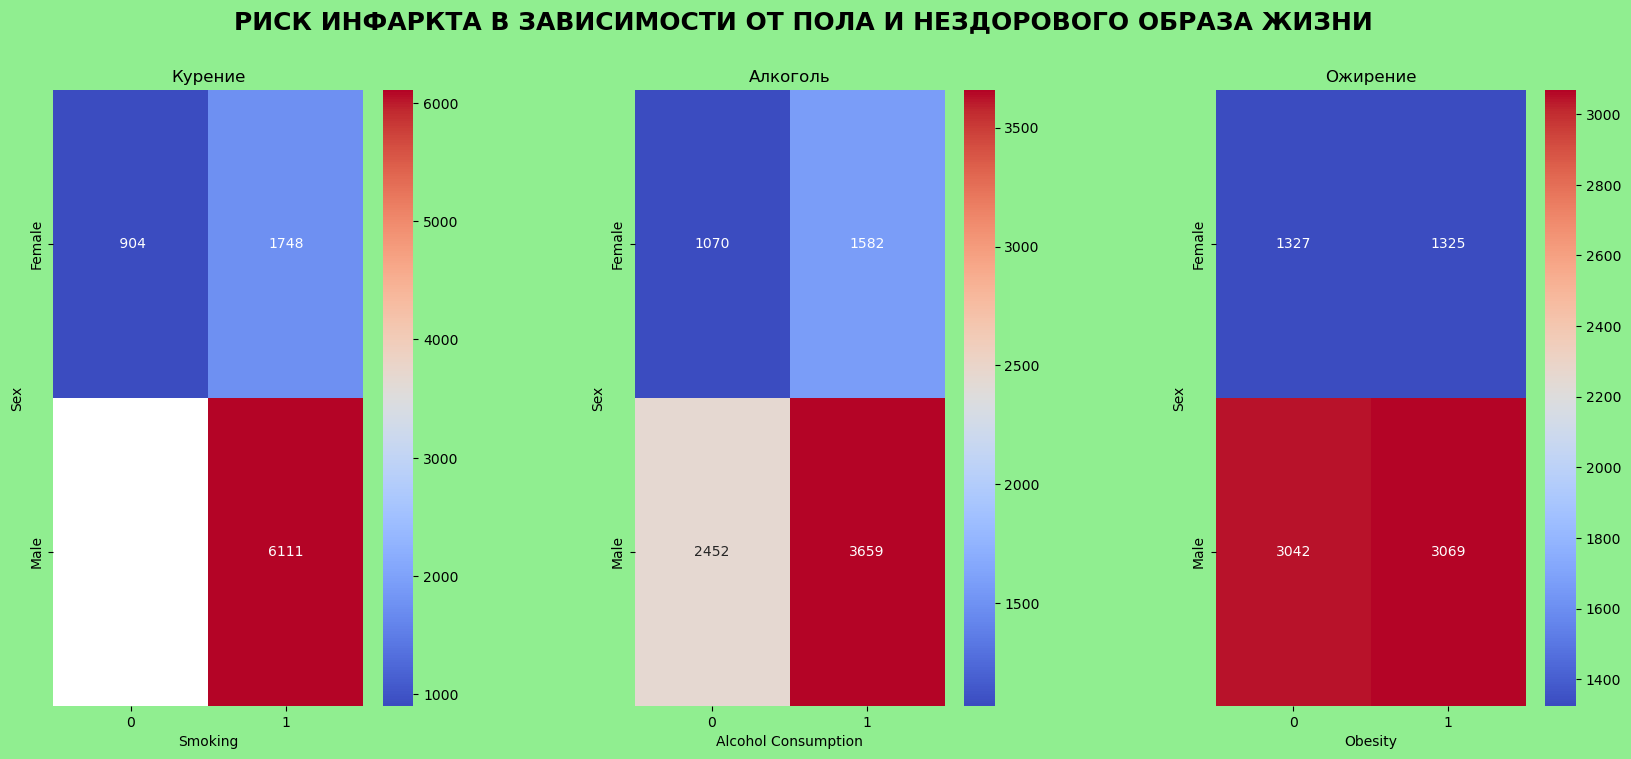

In [110]:
# Создаем сводную таблицу для пациентов по полу и курению
smoking_and_sex = pd.pivot_table(data,
                       values='Heart Attack Risk',
                       columns='Smoking',
                       index='Sex',
                       aggfunc='count'
                          )

# Создаем сводную таблицу для пациентов по полу и употреблению алкоголя
alcohol_and_sex = pd.pivot_table(data,
                       values='Heart Attack Risk',
                       columns='Alcohol Consumption',
                       index='Sex',
                       aggfunc='count'
                          )
# Создаем сводную таблицу для пациентов по полу и ожирению
obesity_and_sex = pd.pivot_table(data,
                       values='Heart Attack Risk',
                       columns='Obesity',
                       index='Sex',
                       aggfunc='count'
                          )
# Строим тепловые карты
fig, axes = plt.subplots(1, 3, figsize=(20, 8),
                         facecolor='lightgreen')
# Название графика
plt.suptitle('Риск инфаркта в зависимости от пола и нездорового образа жизни'.upper(),
            fontsize=18,
            fontweight='bold')
# Пространство между графиками
plt.subplots_adjust(wspace=0.5,
                    hspace=0.2)
# Курение и пол
heat1 = sns.heatmap(data=smoking_and_sex,
                      cmap='coolwarm',
                      annot=True,
                      fmt='4g',
                      ax=axes[0])
heat1.set_title('Курение')
# Алкоголь и пол
heat2 = sns.heatmap(data=alcohol_and_sex,
                      cmap='coolwarm',
                      annot=True,
                      fmt='4g',
                      ax=axes[1])
heat2.set_title('Алкоголь')
# Ожирение и пол
heat3 = sns.heatmap(data=obesity_and_sex,
                      cmap='coolwarm',
                      annot=True,
                      fmt='4g',
                      ax=axes[2])
heat3.set_title('Ожирение');

Из представленных признаков у куриения наибольшее влияние на риск инфаркта. Среди курящих мужчин отстутствуют пациенты, не имеющие риск инфаркта, а среди женщин такие есть. На втором месте по влиянию употребление алкоголя. По всем трем признакам наибольшее количество - мужчины. Это также связано с тем, что их доля в выборке выше. У женщин также все три показателя выше у риска инфаркта, но в этой категории выше доля пациентов без риска. Возможно женщины реже обследуются на наличние риска инфаркта.

Далее рассмотрим связь уровня стресса и нездорового образа жизни

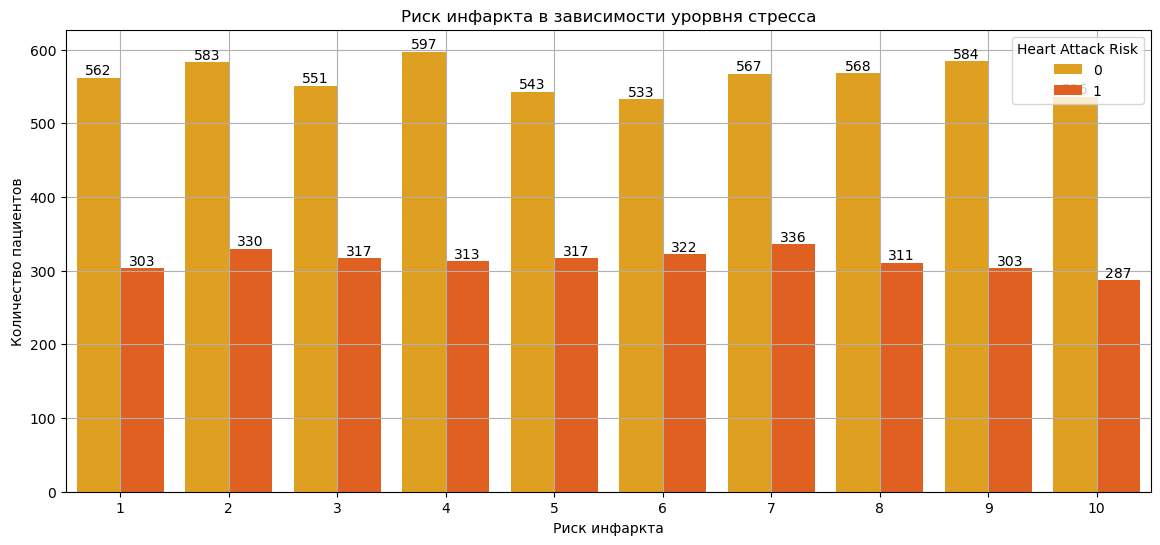

In [112]:
stress = data.groupby(by='Stress Level', as_index=False)['Heart Attack Risk'].value_counts()

# Педставим в вие столбчатой диаграммы
plt.rcParams['figure.figsize'] = (14, 6)
bar = sns.barplot(stress,
         x='Stress Level',        
         y='count',
         hue='Heart Attack Risk',
         palette='autumn_r'
         )
bar.bar_label(bar.containers[0])
bar.bar_label(bar.containers[1])
bar.set_title('Риск инфаркта в зависимости урорвня стресса')
bar.set_xlabel('Риск инфаркта')
bar.set_ylabel('Количество пациентов')
bar.grid()

In [113]:
data['Heart Attack Risk'].corr(data['Stress Level'], method='spearman')

-0.004115397580984681

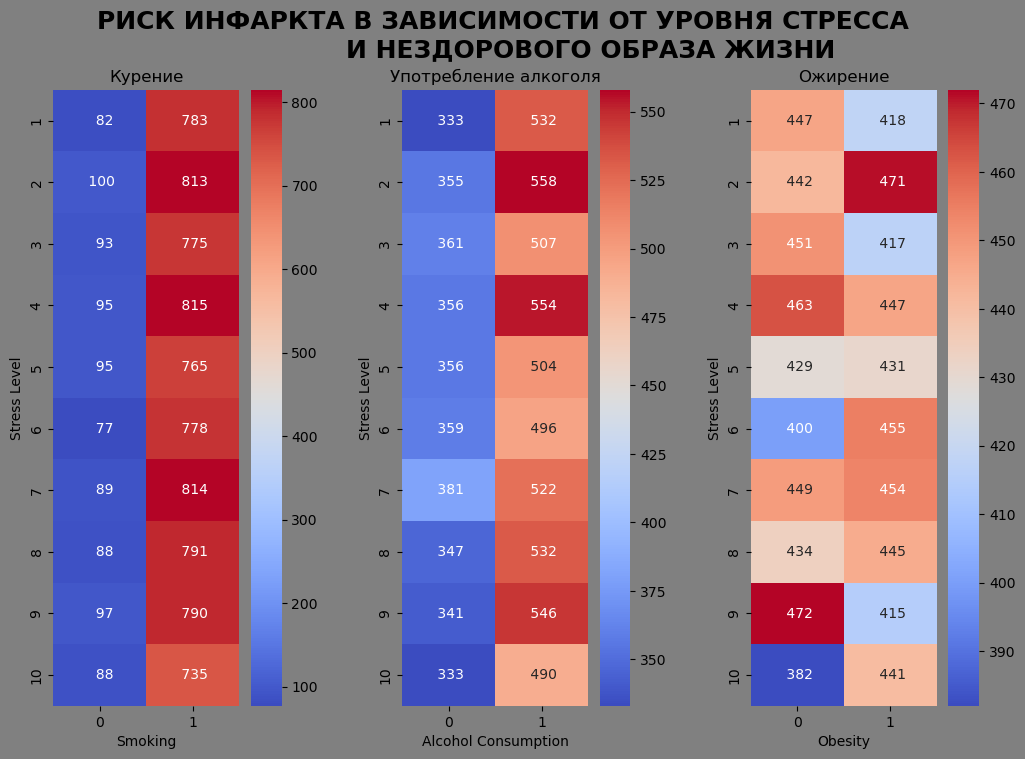

In [114]:
# Создаем сводную таблицу для пациентов по уровню стресса и курению
smoking_and_stress = pd.pivot_table(data,
                       values='Heart Attack Risk',
                       columns='Smoking',
                       index='Stress Level',
                       aggfunc='count'
                          )

# Создаем сводную таблицу для пациентов по уровню стресса и употреблению алкоголя
alcohol_and_stress = pd.pivot_table(data,
                       values='Heart Attack Risk',
                       columns='Alcohol Consumption',
                       index='Stress Level',
                       aggfunc='count'
                          )
# Создаем сводную таблицу для пациентов по уровню стресса и ожирению
obesity_and_stress = pd.pivot_table(data,
                       values='Heart Attack Risk',
                       columns='Obesity',
                       index='Stress Level',
                       aggfunc='count'
                          )
# Строим тепловые карты
fig, axes = plt.subplots(1, 3, figsize=(12, 8), facecolor='grey')
# Название графика
plt.suptitle('''Риск инфаркта в зависимости от уровня стресса
                    и нездорового образа жизни'''.upper(),
            fontsize=18,
            fontweight='bold')
plt.subplots_adjust(wspace=0.5,
                    hspace=0.5)
# Стресс и курение
heat1 = sns.heatmap(data=smoking_and_stress,
                      cmap='coolwarm',
                      annot=True,
                      fmt='4',
                      ax=axes[0])
heat1.set_title('Курение')
# Стресс и употребление алкоголя
heat2 = sns.heatmap(data=alcohol_and_stress,
                      cmap='coolwarm',
                      annot=True,
                      fmt='4',
                      ax=axes[1])
heat2.set_title('Употребление алкоголя')
# Стресс и ожирение
heat3 = sns.heatmap(data=obesity_and_stress,
                      cmap='coolwarm',
                      annot=True,
                      fmt='4',
                      ax=axes[2])
heat3.set_title('Ожирение');

Уровень стресса не оказывает значительного влияния на риск инфаркта. В сочетании с вредными привычками риск повышается. Особенно это связано с курением. Алкоголь и ожирение в сочетании со стрессом не оказывают значительного влияния на риск инфаркта.

## <center> **3. Подготовка данных**

### 3.1. Кодирование нечиловых признаков

In [115]:
# Создаем копию датасета
train_data = data.copy()

In [116]:
# Закодируем признак 'Sex':
# Male: 1
# Female: 0
train_data['Sex'] = train_data['Sex'].apply(lambda x: 1 if x == 'Male' else 0)

# Закодируем признак 'Hemisphere':
# Northern Hemisphere: 1
# Southern Hemisphere: 0
train_data['Hemisphere'] = train_data['Hemisphere'].apply(lambda x: 1 if x == 'Northern Hemisphere' else 0)

In [117]:
# Кодируем признаки 'Diet', 'Continent', 'Age group', 'Country',
# 'Physical activity group', 'income group' с помощью OneHotEncoder
# Список признаков для кодирования
features = ['Diet', 'Continent', 'Age group', 'Physical activity group', 'income group', 'Country']
# Создаем объект OneHotEncoder
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
# Трансформируем признаки и присваиваем имена столбцов таблицы
data_encode = encoder.fit_transform(train_data[features])
column_names = encoder.get_feature_names_out(features)
# Добавляем закодированные признаки в датафрейм
data_encode = pd.DataFrame(data_encode, columns=column_names)
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(features, axis=1), data_encode],
    axis=1
)
print(f'Количество признаков в исходном датасете {data.shape}')
print(f'Количество признаков в закодированном датасете {train_data.shape}')

Количество признаков в исходном датасете (8763, 25)
Количество признаков в закодированном датасете (8763, 59)


### 3.2. Корреляция, отбор признаков

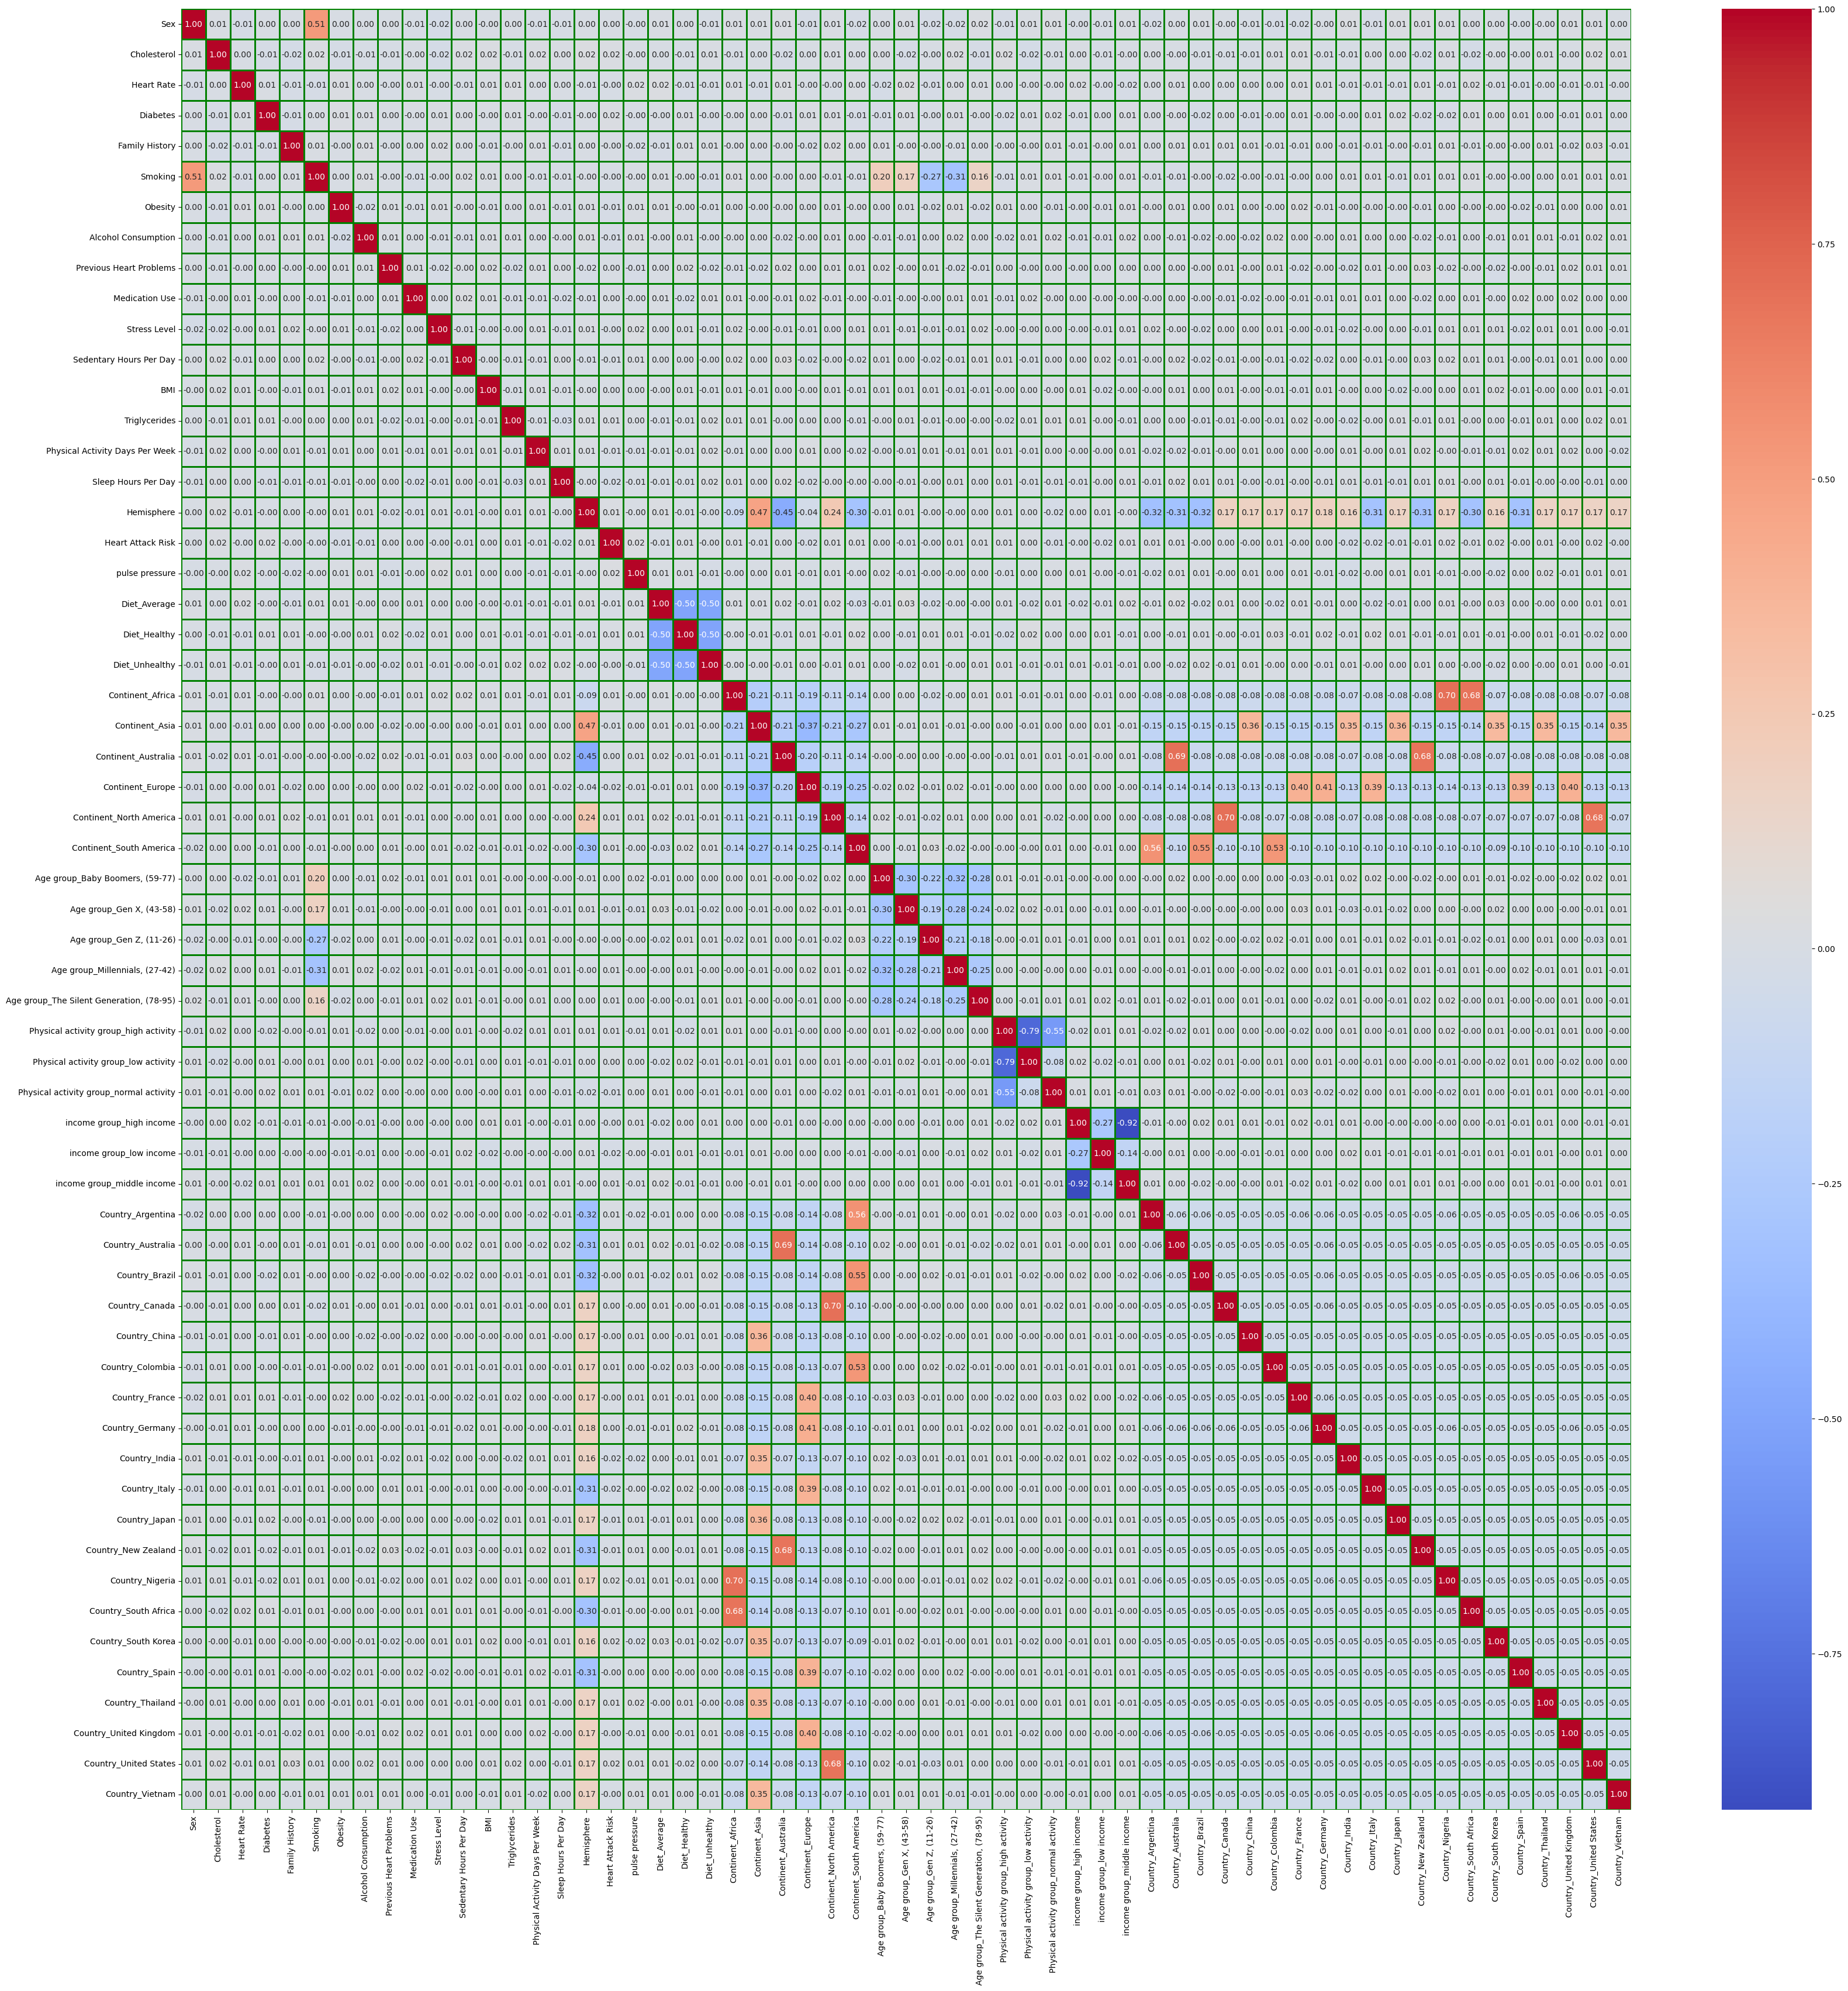

In [118]:
# Создаем матрицу корреляции для признаков
fig = plt.figure(figsize=(40, 40))
corr_map = sns.heatmap(train_data.corr(),
                      annot=True,
                      fmt='.2f',
                      cmap='coolwarm',
                      linewidth=2,
                      linecolor='green')

In [119]:
print(f'Определитель матрицы = {round(np.linalg.det(train_data.corr()))}')
print(f'Ранг матрицы = {round(np.linalg.matrix_rank(train_data.corr()))}')
print(f'Размерность матрицы = {train_data.corr().shape}')

Определитель матрицы = 0
Ранг матрицы = 47
Размерность матрицы = (59, 59)


Корреляционная матрица порядка 59. Определитель = 0, ранг квадратной матрицы меньше ее размерности. Таким образом матрия является вырожденной, имеет мультиколлениарные признаки.

Отберем значимые для обцчения признаки с помощью теста ANOVA

In [120]:
# Обучающая матрица
X = train_data.drop('Heart Attack Risk', axis=1)
# Вектор правильных ответов
y = train_data['Heart Attack Risk']

In [121]:
# Значимые признаки по ANOVA тесту
def best_features_anova(X, y):
    selector = SelectKBest(f_classif, k=25)
    selector.fit(X, y)
    best_features = selector.get_feature_names_out()
    return best_features

features_anova = best_features_anova(X, y)
print(features_anova)

['Cholesterol' 'Diabetes' 'Obesity' 'Alcohol Consumption' 'Triglycerides'
 'Sleep Hours Per Day' 'Hemisphere' 'pulse pressure' 'Diet_Average'
 'Diet_Healthy' 'Continent_Europe' 'Continent_North America'
 'Age group_Gen X, (43-58)' 'Physical activity group_normal activity'
 'income group_low income' 'income group_middle income' 'Country_Colombia'
 'Country_India' 'Country_Italy' 'Country_Japan' 'Country_Nigeria'
 'Country_South Africa' 'Country_South Korea' 'Country_Thailand'
 'Country_United States']


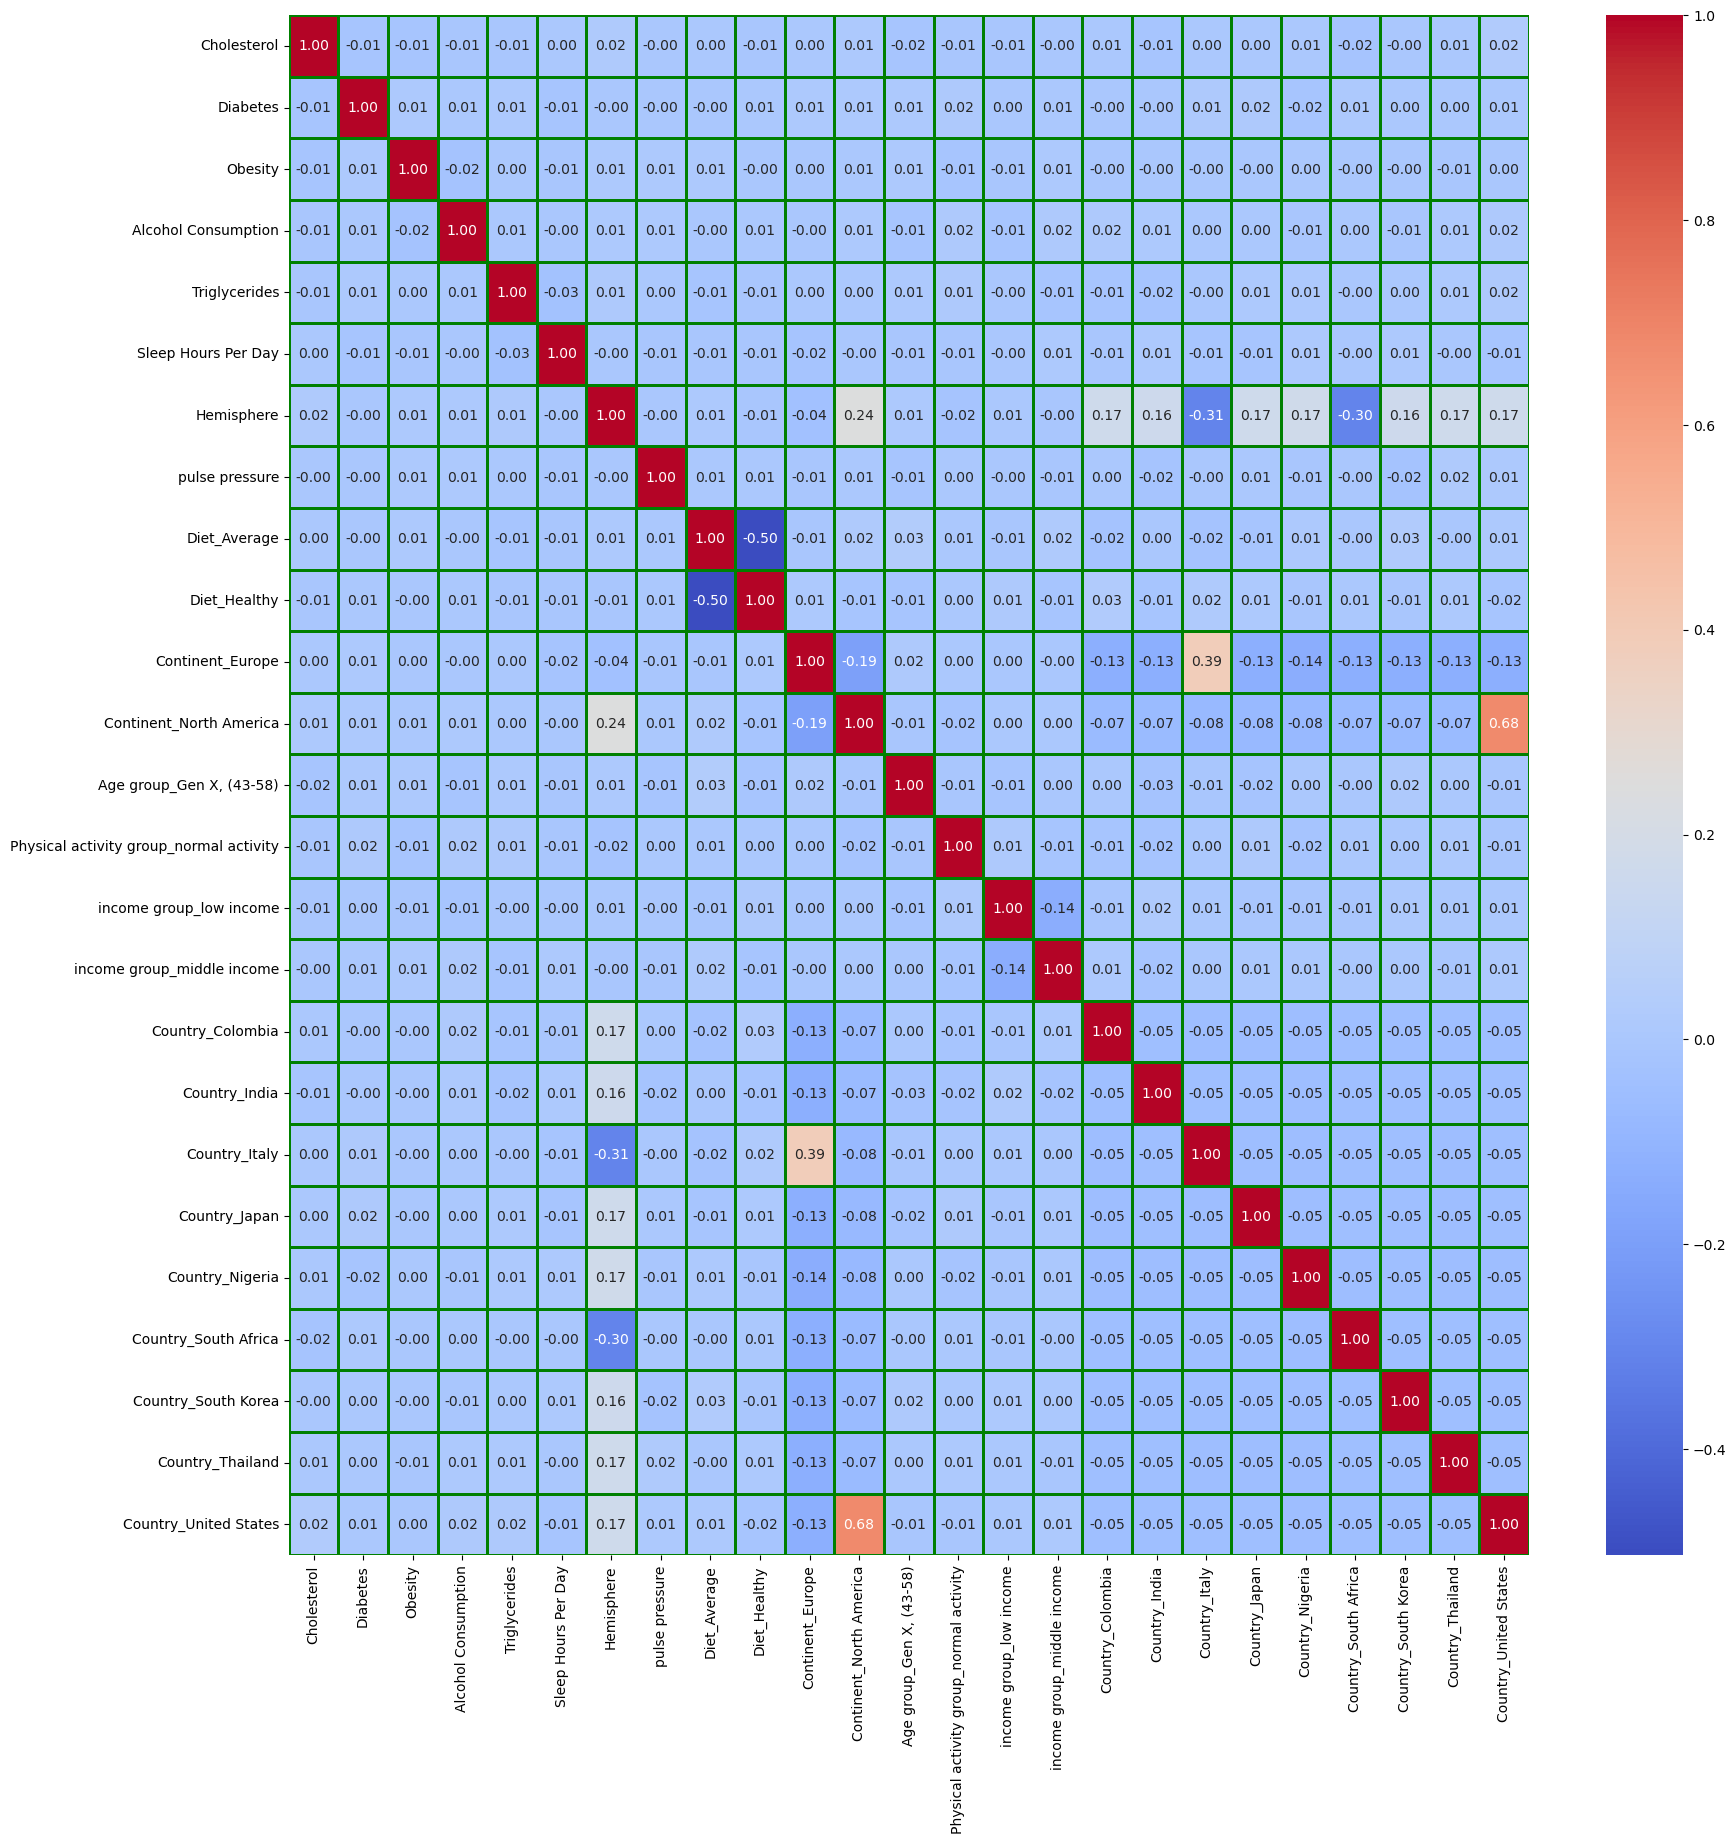

In [122]:
# Создаем матрицу корреляции для признаков
fig = plt.figure(figsize=(20, 20))
corr_map = sns.heatmap(train_data[features_anova].corr(),
                      annot=True,
                      fmt='.2f',
                      cmap='coolwarm',
                      linewidth=2,
                      linecolor='green')

In [123]:
print(f'Определитель матрицы = {round(np.linalg.det(train_data[features_anova].corr()))}')
print(f'Ранг матрицы = {round(np.linalg.matrix_rank(train_data[features_anova].corr()))}')
print(f'Размерность матрицы = {train_data[features_anova].corr().shape}')

Определитель матрицы = 0
Ранг матрицы = 25
Размерность матрицы = (25, 25)


Ранг матрицы стал равен ее размерности

In [124]:
# Обучающая матрица из значимых признаков
X = train_data[features_anova]

## <center> **4. Перебалансировка классов**

Проблема работы с несбалансированными наборами данных заключается в том, что большинство методов машинного обучения игнорируют класс меньшинства и, в свою очередь, имеют низкую производительность.

В SMOTE (техника синтезированной миноритарной передискретизации) мы создаем элементы в непосредственной близости от существующих в меньшем наборе.

Используя SMOTE, синтетические выборки генерируются следующим образом: берут разницу между рассматриваемым вектором признаков и его ближайшим соседом. Мы умножаем эту разницу на случайное число от 0 до 1 и добавляем его к рассматриваемому вектору признаков.

Это вызывает выбор случайной точки на отрезке линии между двумя конкретными объектами. Такой подход фактически вынуждает класс меньшинства принимать более общие решения.

In [125]:
# Создаем объект SMOTE
smote = SMOTE(random_state=42, n_jobs=-1)
# Обучаем модель
X_sm, y_sm = smote.fit_resample(X, y)

Heart Attack Risk  count  percent
0                  0   5624     50.0
1                  1   5624     50.0

Размерность оригинальной обучающей выбокри (8763, 25)
Размерность оригинального вектора правильных ответов (8763,)
Размерность сбалансированной обучающей выбокри (11248, 25)
Размерность сбалансированного вектора правильных ответов (11248,)


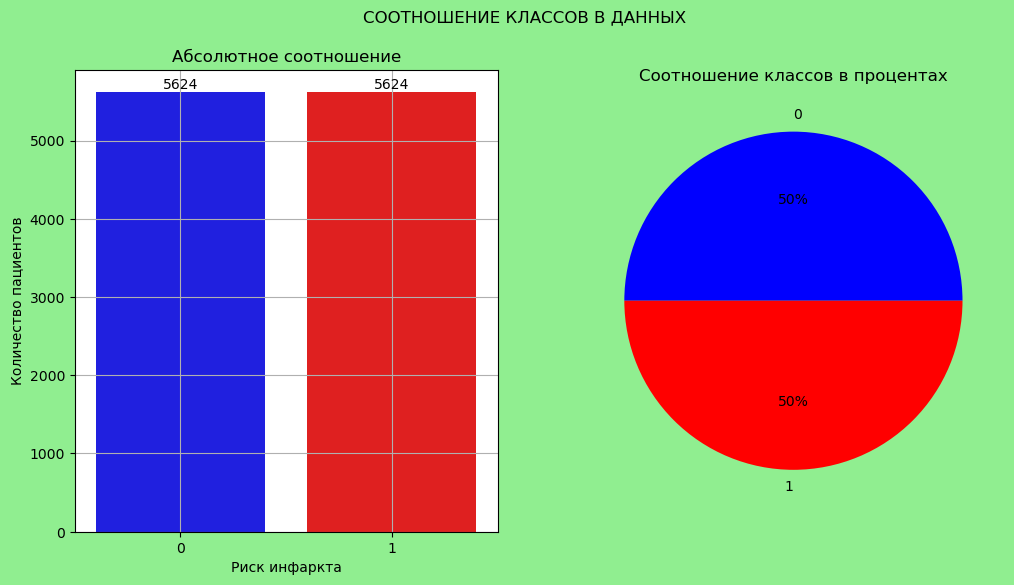

In [126]:
# Объединяем обученные данные
df_smoted = pd.concat([X_sm, y_sm], axis=1)
# Считаем количество значений для каждого класса
classes_sm = df_smoted['Heart Attack Risk'].value_counts().reset_index()
# Рассчитываем долю пациентов в каждом классе
classes_sm['percent'] = round(classes_sm['count'] / classes_sm['count'].sum() * 100)

display(classes_sm)
print(f'Размерность оригинальной обучающей выбокри {X.shape}')
print(f'Размерность оригинального вектора правильных ответов {y.shape}')
print(f'Размерность сбалансированной обучающей выбокри {X_sm.shape}')
print(f'Размерность сбалансированного вектора правильных ответов {y_sm.shape}')

# Строим график
balance_plot(classes_sm)

Компании часто сталкиваются с проблемой, когда им не хватает реальных данных или они не могут использовать реальные данные из соображений конфиденциальности. Здесь на помощь приходит генерация синтетических данных. Исследователи и специалисты по обработке данных используют синтетические данные для создания новых продуктов, повышения производительности моделей машинного обучения, замены конфиденциальных данных и экономии затрат на получение данных. Подробнее читайте в The Ultimate Guide to Synthetic Data .

Синтетические данные используются в секторе здравоохранения, беспилотных автомобилях, финансовом секторе, обеспечивая высокий уровень конфиденциальности, а также в исследовательских целях.

Для создания синтетических табличных данных мы будем использовать условные генеративно-состязательные сети из библиотек Python с открытым исходным кодом под названием CTGAN.

In [127]:
# Создаем и обучаем CTGAN
ctgan = CTGAN()
ctgan.fit(df_smoted)

# Создаем синтетические данные
synthetic_df = ctgan.sample(100000)
synthetic_df.head()

Cholesterol  Diabetes  Obesity  Alcohol Consumption  Triglycerides  \
0          278         0        1                    1            537   
1          267         0        0                    0            332   
2          176         1        0                    1            193   
3          383         1        1                    1            232   
4          262         1        1                    1            316   

   Sleep Hours Per Day  Hemisphere  pulse pressure  Diet_Average  \
0                    9           1               8      0.002356   
1                    6           0              49     -0.001701   
2                    4           0              80      0.002583   
3                   10           1              18      1.000398   
4                    4           1              -2      0.002714   

   Diet_Healthy  ...  Country_Colombia  Country_India  Country_Italy  \
0      0.002086  ...         -0.000746      -0.001688       0.001759   
1      0.000624  ...          0.000098      -0.000889      -0.000753   
2      0.000127  ...          0.000761      -0.001366       0.001246   
3     -0.001265  ...         -0.000759      -0.001100       0.000950   
4      0.002358  ...          0.000158      -0.002164       0.000205   

   Country_Japan  Country_Nigeria  Country_South Africa  Country_South Korea  \
0      -0.002016         0.001298              0.001149             0.000331   
1      -0.001434         0.000408              0.000783             0.000305   
2      -0.001500         0.002381              0.000655            -0.000319   
3      -0.001470        -0.000253             -0.000135            -0.000629   
4       0.000260         0.000972             -0.001206            -0.000357   

   Country_Thailand  Country_United States  Heart Attack Risk  
0          0.000179               0.000460                  1  
1          0.000463              -0.000977                  1  
2          0.475455              -0.000990                  0  
3          0.001070               0.968228                  0  
4          1.009703               0.001342                  0  

[5 rows x 26 columns]

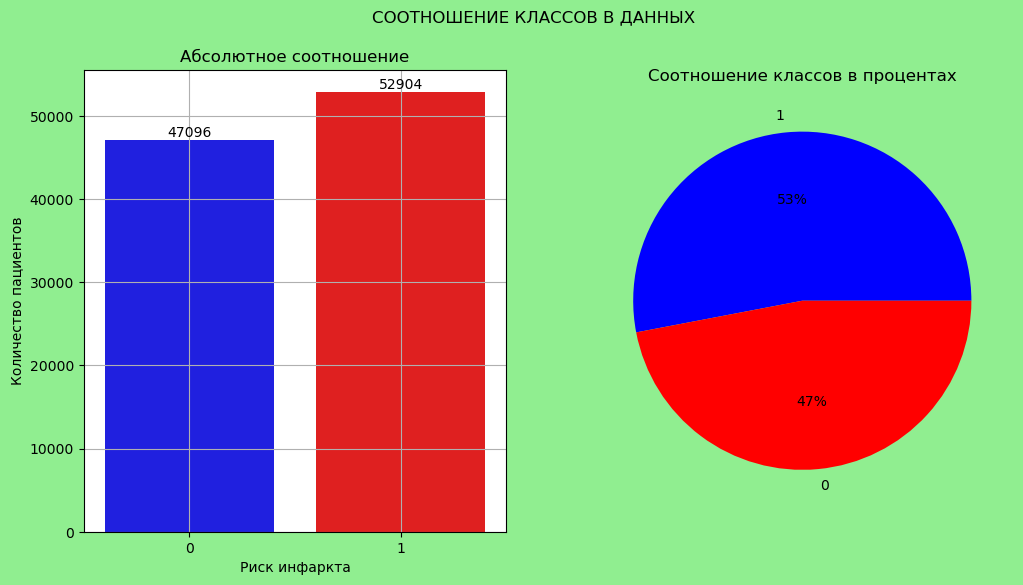

In [128]:
classes = synthetic_df['Heart Attack Risk'].value_counts().reset_index()
classes['percent'] = round(classes['count'] / classes['count'].sum() * 100)
classes

balance_plot(classes)

## <center> **5. Подбор и обучение модели**

**Сбалансированная точность (Balanced Accuracy)**

В случае дисбаланса классов есть специальный аналог accuracy – сбалансированная accuracy - это среднее полноты всех классов, ну или в других терминах: среднее чувствительности (Sensitivity) и специфичности (Specificity).:

$BA = \frac{R_1 + R_0}{2} = \frac{1}{2}(\frac{TP}{TP + FN} + \frac{TN}{TN + FP})$

Accuracy показывает количество правильно проставленных меток класса (истинно положительных и истинно отрицательных) от общего количества данных.

**Recall (true positive rate)**

В русском языке для этого термина используется слово «полнота» или «чувствительность». Эта метрика определяет количество истинно положительных среди всех меток класса, которые были определены как «положительный» и вычисляется по следующей формуле

$Recall = \frac{TP}{TP + FN}$

При определении риска инфаркта цена ошибки нераспознания положительного класса слишком велика, поэтому используем эту метрику.


In [53]:
def get_metrics(y_train, y_train_pred, y_test, y_test_pred):
    '''
    Функция возвращает словарь со  заначениями метрик Balanced accuracy и Recall
    '''
    metric_dict = {
    # Balanced Accuracy
    'Balanced Accuracy train' : round(metrics.balanced_accuracy_score(y_train, y_train_pred), 2),
    'Balanced Accuracy test' : round(metrics.balanced_accuracy_score(y_test, y_test_pred), 2),    
    # Recall
    'Recall train' : round(metrics.recall_score(y_train, y_train_pred), 2),
    'Recall test' : round(metrics.recall_score(y_test, y_test_pred), 2)    
    }
    return metric_dict

Разделим данные на обучающие и тестовые выборки

In [54]:
# Матрица для обучения
X = synthetic_df.drop('Heart Attack Risk', axis=1)
# Вектор правильных ответов
y = synthetic_df['Heart Attack Risk']
# Разделяем выборку в соотношении 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)
print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (80000, 25)
X_test: (20000, 25)
y_train: (80000,)
y_test: (20000,)


In [55]:
# Шкалируем датафрем
# Снижаем размерность до 2 признаков
pipeline_pca = Pipeline([('scaler', preprocessing.StandardScaler()),
                              ('pca', decomposition.PCA(n_components=2))])
X_pca = pipeline_pca.fit_transform(X)
# Смотрим какую долю дисперсии объясняет каждая из компонент
variance = [round(x, 2) for x in pipeline_pca['pca'].explained_variance_ratio_]
variance

[0.08, 0.06]

axis-1    axis-2  Heart Attack Risk
0 -1.348374  1.801061                  1
1  0.441413 -1.644965                  0
2 -2.311059  0.567943                  1
3  0.196127  1.121755                  1
4 -0.180347 -2.302527                  1

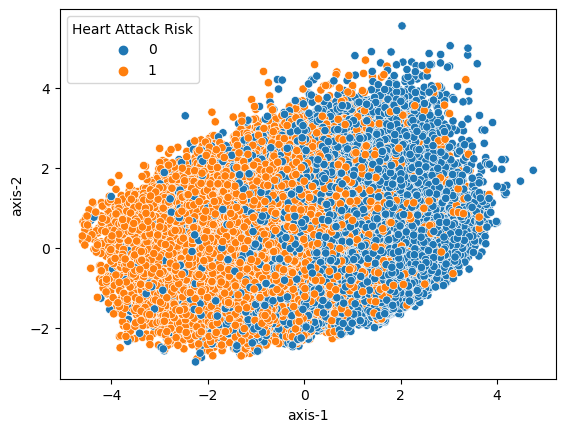

In [56]:
# Создаем датафрейм из трансформированных данных
df_pca = pd.DataFrame(X_pca, columns=['axis-1', 'axis-2'])
df_pca_y = pd.concat([df_pca, y], axis=1)
display(df_pca_y.head())

# Визуализируем данные по классам
scat = sns.scatterplot(df_pca_y,
                       x='axis-1',
                       y='axis-2',
                       hue='Heart Attack Risk')

### 5.1. Logistic Regression

In [57]:
# Создаем объект логистической регрессии
logreg = linear_model.LogisticRegression(max_iter=5000, random_state=42, n_jobs=-1)
# Обучаем модель
logreg.fit(X_train, y_train)
# Предсказание
y_train_pred_lg = logreg.predict(X_train)
y_test_pred_lg = logreg.predict(X_test)
# Метрики
metrics_lg = pd.Series(get_metrics(y_train, y_train_pred_lg, y_test, y_test_pred_lg)).reset_index()
metrics_lg = metrics_lg.rename(columns={'index' : 'Logistic Regression',
                                       0 : 'score'})
display(metrics_lg)

Logistic Regression  score
0  Balanced Accuracy train   0.72
1   Balanced Accuracy test   0.72
2             Recall train   0.75
3              Recall test   0.74

In [58]:
# Обучим логистическую регрессию на шкалированных данных
pipeline_lg = Pipeline([
                       ('scaler', preprocessing.StandardScaler()),
                       ('logreg', linear_model.LogisticRegression(max_iter=5000,
                                                                  random_state=42,
                                                                  n_jobs=-1))]
                       )
pipeline_lg.fit(X_train, y_train)

y_train_pred_lg = pipeline_lg.predict(X_train)
y_test_pred_lg = pipeline_lg.predict(X_test)

metrics_lg_scal = pd.Series(get_metrics(y_train, y_train_pred_lg, y_test, y_test_pred_lg)).reset_index()
metrics_lg_scal = metrics_lg_scal.rename(columns={'index' : 'Logistic Regression scal',
                                       0 : 'score'})
display(metrics_lg_scal)

Logistic Regression scal  score
0  Balanced Accuracy train   0.72
1   Balanced Accuracy test   0.72
2             Recall train   0.75
3              Recall test   0.74

### 5.2 Polynomial Regression

Судя по графику PCA данные сложно разделить одной линией. Попробуем полиномиальную регрессию.

In [59]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3)
poly.fit(X_train)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test)
#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)

(80000, 3276)
(20000, 3276)


In [60]:
# Создаем пайплайн шкалированных признаков и логистической регрессии
pipeline_lg_poly = Pipeline([
                       ('scaler', preprocessing.StandardScaler()),
                       ('logreg', linear_model.LogisticRegression(max_iter=5000,                                                                  
                                                                  random_state=42,
                                                                  n_jobs=-1))]
                       )
# Обучение пайплайна
pipeline_lg_poly.fit(X_train_poly, y_train)
# Предсказание
y_train_pred_lg_poly = pipeline_lg_poly.predict(X_train_poly)
y_test_pred_lg_poly = pipeline_lg_poly.predict(X_test_poly)
# Метрики
metrics_lg_scal_poly = pd.Series(get_metrics(y_train, y_train_pred_lg_poly, y_test, y_test_pred_lg_poly)).reset_index()
metrics_lg_scal_poly = metrics_lg_scal_poly.rename(columns={'index' : 'Logistic Poly Regression',
                                       0 : 'score'})
display(metrics_lg_scal_poly)

Logistic Poly Regression  score
0  Balanced Accuracy train   0.76
1   Balanced Accuracy test   0.73
2             Recall train   0.77
3              Recall test   0.74

### 5.3 Support Vector Machines

In [61]:
pipeline_svm = Pipeline([
                       ('scaler', preprocessing.StandardScaler()),
                       ('svc', svm.SVC(kernel='rbf', random_state=42))]
                       )

pipeline_svm.fit(X_train, y_train)

y_train_pred_svm = pipeline_svm.predict(X_train)
y_test_pred_svm = pipeline_svm.predict(X_test)

metrics_svm = pd.Series(get_metrics(y_train, y_train_pred_svm, y_test, y_test_pred_svm)).reset_index()
metrics_svm = metrics_svm.rename(columns={'index' : 'SVM',
                                       0 : 'SVM score'})
display(metrics_svm)

SVM  SVM score
0  Balanced Accuracy train       0.76
1   Balanced Accuracy test       0.73
2             Recall train       0.77
3              Recall test       0.74

### 5.4 K-Nearest Neighbor

In [62]:
# В цикле переберем значение количества ближайших соседей
for i in list(range(3, 10)):   
    knn = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    # Обучаем модель с i ближайших соседей
    knn.fit(X_train, y_train)
    # Предсказание
    y_train_pred_knn = knn.predict(X_train)
    y_test_pred_knn = knn.predict(X_test)
    # Метрики
    metrics_knn = pd.Series(get_metrics(y_train, y_train_pred_knn, y_test, y_test_pred_knn)).reset_index()
    metrics_knn = metrics_knn.rename(columns={'index' : 'KNN',
                                           0 : 'KNN score'})
    print(f'n_neighbors={i}')
    display(metrics_knn)
    print()

n_neighbors=3


KNN  KNN score
0  Balanced Accuracy train       0.76
1   Balanced Accuracy test       0.52
2             Recall train       0.80
3              Recall test       0.58


n_neighbors=4


KNN  KNN score
0  Balanced Accuracy train       0.71
1   Balanced Accuracy test       0.52
2             Recall train       0.58
3              Recall test       0.40


n_neighbors=5


KNN  KNN score
0  Balanced Accuracy train       0.70
1   Balanced Accuracy test       0.52
2             Recall train       0.76
3              Recall test       0.59


n_neighbors=6


KNN  KNN score
0  Balanced Accuracy train       0.68
1   Balanced Accuracy test       0.52
2             Recall train       0.60
3              Recall test       0.45


n_neighbors=7


KNN  KNN score
0  Balanced Accuracy train       0.67
1   Balanced Accuracy test       0.52
2             Recall train       0.74
3              Recall test       0.61


n_neighbors=8


KNN  KNN score
0  Balanced Accuracy train       0.66
1   Balanced Accuracy test       0.53
2             Recall train       0.61
3              Recall test       0.48


n_neighbors=9


KNN  KNN score
0  Balanced Accuracy train       0.65
1   Balanced Accuracy test       0.52
2             Recall train       0.73
3              Recall test       0.61

### 5.5. Decision tree classifier

In [63]:
# Сетка гиперпараметров
param_grid = {
             'criterion' : ['gini', 'entropy'], # критерий качества разделения
             'max_depth' : range(3, 200, 10), # максимальная глубина дерева 
             'min_samples_split' : range(2, 8, 1), # минимальное количество выборок, необходимых для разделения
             'min_samples_leaf' : range(1, 8, 1), #  минимально количество выборок на листе
             'max_features' : ['sqrt', 'log2'] # количество признаков для лучшего разделения
}
# Создаем объект gridsearch с кроссвалидацией на 5 фолдах
grid_search_dt = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    verbose=3,
    n_jobs=-1
)
# Обучаем модель
%time grid_search_dt.fit(X_train, y_train)

# Предсказание
y_train_pred_grid_dt = grid_search_dt.predict(X_train)
y_test_pred_grid_dt = grid_search_dt.predict(X_test)

# Гиперпараметры
print(f'Лучшие гиперпараметры: {(grid_search_dt.best_params_)}')

Fitting 5 folds for each of 3360 candidates, totalling 16800 fits


CPU times: total: 12min 46s
Wall time: 17min 19s
Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 7}


Лучшие гиперпараметры: {'criterion': 'entropy', 'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7}

In [81]:
metrics_grid_dt = pd.Series(get_metrics(y_train, y_train_pred_grid_dt, y_test, y_test_pred_grid_dt)).reset_index()
metrics_grid_dt = metrics_grid_dt.rename(columns={'index' : 'Decision tree best params',
                                                  0 : 'score_DT'})
metrics_grid_dt

Decision tree best params  score_DT
0   Balanced Accuracy train      0.76
1    Balanced Accuracy test      0.70
2              Recall train      0.76
3               Recall test      0.70

### 5.6. Random Forest Classifier

In [64]:
# Функция обучает модели и подбирает гиперпараметры с помощью optuna
def optuna_rf(trial):
  # Задаем пространство для подбора гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 50, 800, 50) # количество деревьев
  max_depth = trial.suggest_int('max_depth', 1, 8, 1) # максимальная глубина дерева
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8, 1) #  минимально количество выборок на листе
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 8) # максимальное количество личтьев в узле

  # Создаем модель
  model = ensemble.RandomForestClassifier(
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      max_leaf_nodes=max_leaf_nodes,
                                      criterion='entropy', # критерий качества разделения
                                      max_features='sqrt', # количество признаков для лучшего разделения
                                      random_state=42
                                      )
  # Train the model
  model.fit(X_train, y_train)

  # Значение метрики Recall с кросс-валидацией на 5 фолдах
  score = cross_val_score(model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)

  # Возвращаем среднее значение по кросс-валидации
  return score.mean()

In [65]:
# Создаем объект для исследования
# Максимизируем метрику
study = optuna.create_study(study_name='DecisionTreeClassifier', direction='maximize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-03-05 20:02:37,430] A new study created in memory with name: DecisionTreeClassifier
[I 2024-03-05 20:04:00,368] Trial 0 finished with value: 0.7812218801799669 and parameters: {'n_estimators': 350, 'max_depth': 6, 'min_samples_leaf': 6, 'max_leaf_nodes': 8}. Best is trial 0 with value: 0.7812218801799669.
[I 2024-03-05 20:04:59,425] Trial 1 finished with value: 0.7972057778830214 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_leaf': 7, 'max_leaf_nodes': 3}. Best is trial 1 with value: 0.7972057778830214.
[I 2024-03-05 20:06:21,679] Trial 2 finished with value: 0.7957376272791854 and parameters: {'n_estimators': 550, 'max_depth': 4, 'min_samples_leaf': 2, 'max_leaf_nodes': 3}. Best is trial 1 with value: 0.7972057778830214.
[I 2024-03-05 20:09:17,299] Trial 3 finished with value: 0.7771015865498461 and parameters: {'n_estimators': 750, 'max_depth': 5, 'min_samples_leaf': 2, 'max_leaf_nodes': 8}. Best is trial 1 with value: 0.7972057778830214.
[I 2024-03-05 20

In [66]:
# График истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name='recall')

In [67]:
print(f'Лучшие значения гиперпараметров {study.best_params}')
print('Recall не тренировочной выборке: {:.2f}'.format(study.best_value))

Лучшие значения гиперпараметров {'n_estimators': 700, 'max_depth': 8, 'min_samples_leaf': 5, 'max_leaf_nodes': 2}
Recall не тренировочной выборке: 0.82


In [68]:
# Обучаем модель с лучшими гиперпараметрами
model_rf = ensemble.RandomForestClassifier(**study.best_params,
                                      criterion='entropy',
                                      max_features='sqrt',
                                      random_state=42)

model_rf.fit(X_train, y_train)

# Делаем предсказание
y_train_pred_rf = model_rf.predict(X_train)
y_test_pred_rf = model_rf.predict(X_test)

# Метрики
metrics_rf = pd.Series(get_metrics(y_train, y_train_pred_rf, y_test, y_test_pred_rf)).reset_index()
metrics_rf = metrics_rf.rename(columns={'index' : 'Random Forest',
                                       0 : 'score_RF'})
display(metrics_rf)

Random Forest  score_RF
0  Balanced Accuracy train      0.71
1   Balanced Accuracy test      0.70
2             Recall train      0.82
3              Recall test      0.81

In [69]:
# Визуализируем значимые гиперпараметры
optuna.visualization.plot_param_importances(study, target_name='recall')

### 5.7. Gradient Boosting Classifier

In [70]:
# Функция обучает модель, используя подбор гиперпараметров
def optuna_gb(trial):
  # Пространство для подбора гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 800, 50)
  max_depth = trial.suggest_int('max_depth', 1, 8, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 8, 1)
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.9)
  max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 8)

  # Создаем модель
  model = ensemble.GradientBoostingClassifier(n_estimators=n_estimators, # количество деревьев
                                          max_depth=max_depth, # максимальная глубина дерева
                                          min_samples_leaf=min_samples_leaf, # минимальное количество выборок на листе
                                          learning_rate=learning_rate, # темп обучения
                                          criterion='squared_error', # функция потерь
                                          max_features='sqrt', # количество признаков для лучшего разделения
                                          random_state=42)
  # Обучаем модель
  model.fit(X_train, y_train)

  # Значение метрики Recall с кросс-валидацией на 5 фолдах
  score = cross_val_score(model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)

  # Возвращаем среднее значение по кросс-валидации
  return score.mean()

In [71]:
# Создаем объект для исследования
# Максимизируем метрику
study = optuna.create_study(study_name='GradientBoostingClassifier', direction='maximize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_gb, n_trials=20)

[I 2024-03-05 20:28:07,028] A new study created in memory with name: GradientBoostingClassifier
[I 2024-03-05 20:33:35,121] Trial 0 finished with value: 0.7262135922330096 and parameters: {'n_estimators': 700, 'max_depth': 7, 'min_samples_leaf': 4, 'learning_rate': 0.7216202466768535, 'max_leaf_nodes': 2}. Best is trial 0 with value: 0.7262135922330096.
[I 2024-03-05 20:38:16,884] Trial 1 finished with value: 0.719677954061094 and parameters: {'n_estimators': 700, 'max_depth': 6, 'min_samples_leaf': 3, 'learning_rate': 0.8361765233434834, 'max_leaf_nodes': 3}. Best is trial 0 with value: 0.7262135922330096.
[I 2024-03-05 20:41:01,849] Trial 2 finished with value: 0.7250769595074591 and parameters: {'n_estimators': 350, 'max_depth': 7, 'min_samples_leaf': 1, 'learning_rate': 0.6554140767098251, 'max_leaf_nodes': 5}. Best is trial 0 with value: 0.7262135922330096.
[I 2024-03-05 20:46:54,126] Trial 3 finished with value: 0.7373194411555766 and parameters: {'n_estimators': 750, 'max_depth'

In [72]:
# График истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name='recall')

In [73]:
print(f'Лучшие значения гиперпараметров {study.best_params}')
print('Recall не тренировочной выборке: {:.2f}'.format(study.best_value))

Лучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 1, 'learning_rate': 0.014686465480971314, 'max_leaf_nodes': 6}
Recall не тренировочной выборке: 0.76


In [74]:
# Обучаем модель с лучшими гиперпараметрами
model_gb = ensemble.GradientBoostingClassifier(**study.best_params,
                                      criterion='squared_error',
                                      max_features='sqrt',
                                      random_state=42)
model_gb.fit(X_train, y_train)

# Предсказание
y_train_pred_gb = model_gb.predict(X_train)
y_test_pred_gb = model_gb.predict(X_test)

# Метрики
metrics_gb_sn = pd.Series(get_metrics(y_train, y_train_pred_gb, y_test, y_test_pred_gb)).reset_index()
metrics_gb_sn = metrics_gb_sn.rename(columns={'index' : 'Gradient Boosting',
                                       0 : 'score_GB'})
display(metrics_gb_sn)

Gradient Boosting  score_GB
0  Balanced Accuracy train      0.73
1   Balanced Accuracy test      0.72
2             Recall train      0.77
3              Recall test      0.76

### 5.8. XGBOOST

In [75]:
# Функция обучает модель, используя подбор гиперпараметров
def optuna_xgb(trial):
  # Пространство для подбора гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 500, 50)
  max_depth = trial.suggest_int('max_depth', 2, 8, 1)  
  learning_rate = trial.suggest_float('learning_rate', 0.01, 0.9)
  
  # Создаем модель
  model = xgb.XGBClassifier(n_estimators=n_estimators, # количество деревьев
                                          max_depth=max_depth, # максимальная глубина дерева                                          
                                          learning_rate=learning_rate, # темп обучения
                                          eval_metric='logloss', # функция потерь                                          
                                          random_state=42)
  # Обучаем модель
  model.fit(X_train, y_train)

  # Значение метрики Recall с кросс-валидацией на 5 фолдах
  score = cross_val_score(model, X_train, y_train, scoring='recall', cv=5, n_jobs=-1)

  # Возвращаем среднее значение по кросс-валидации
  return score.mean()

In [76]:
# Создаем объект для исследования
# Максимизируем метрику
study = optuna.create_study(study_name='XGBClassifier', direction='maximize')
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_xgb, n_trials=40)

[I 2024-03-05 21:22:16,355] A new study created in memory with name: XGBClassifier
[I 2024-03-05 21:22:23,359] Trial 0 finished with value: 0.7379824769121477 and parameters: {'n_estimators': 450, 'max_depth': 5, 'learning_rate': 0.378186372440669}. Best is trial 0 with value: 0.7379824769121477.
[I 2024-03-05 21:22:26,034] Trial 1 finished with value: 0.7429315652379824 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.7957054647100837}. Best is trial 1 with value: 0.7429315652379824.
[I 2024-03-05 21:22:29,115] Trial 2 finished with value: 0.7490409661378167 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.4691443897966189}. Best is trial 2 with value: 0.7490409661378167.
[I 2024-03-05 21:22:30,461] Trial 3 finished with value: 0.7532796590101822 and parameters: {'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.36506420597945555}. Best is trial 3 with value: 0.7532796590101822.
[I 2024-03-05 21:22:35,524] Trial 4 finished with val

In [77]:
# График истории оптимизации
optuna.visualization.plot_optimization_history(study, target_name='recall')

In [78]:
print(f'Лучшие значения гиперпараметров {study.best_params}')
print('Recall не тренировочной выборке: {:.2f}'.format(study.best_value))

Лучшие значения гиперпараметров {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.023877957078110773}
Recall не тренировочной выборке: 0.76


In [79]:
# Обучаем модель с лучшими гиперпараметрами
model_xgb = xgb.XGBClassifier(n_estimators=100,
                              max_depth=6,
                              learning_rate=0.22864844771508488,                                      
                               eval_metric='logloss',                                      
                                random_state=42)

model_xgb.fit(X_train, y_train)

# Делаем предсказание
y_train_pred_xgb = model_xgb.predict(X_train)
y_test_pred_xgb = model_xgb.predict(X_test)

# Метрики
metrics_xgb = pd.Series(get_metrics(y_train, y_train_pred_xgb, y_test, y_test_pred_xgb)).reset_index()
metrics_xgb = metrics_xgb.rename(columns={'index' : 'XGBOOST',
                                       0 : 'score_XGB'})
display(metrics_xgb)

XGBOOST  score_XGB
0  Balanced Accuracy train       0.81
1   Balanced Accuracy test       0.74
2             Recall train       0.81
3              Recall test       0.74

## <center> **6. Сравнение метрик**

In [82]:
# Создаем датафрейм для сравнения 
metrics = pd.concat([metrics_lg.rename(columns={'Logistic Regression' : 'Metrics', 'score' : 'Logistic Regression'}),
                     metrics_lg_scal['score'].rename('LogReg scal'),
                     metrics_lg_scal_poly['score'].rename('Polynomial Regression'),
                     metrics_svm['SVM score'].rename('SVM'),
                     metrics_grid_dt['score_DT'].rename('Decision Tree'),
                     metrics_rf['score_RF'].rename('Random Forest'),
                     metrics_gb_sn['score_GB'].rename('Gradient Boosting'),
                     metrics_xgb['score_XGB'].rename('XGBoost')],
                    axis=1).set_index('Metrics')

display(metrics)

Logistic Regression  LogReg scal  \
Metrics                                                     
Balanced Accuracy train                 0.72         0.72   
Balanced Accuracy test                  0.72         0.72   
Recall train                            0.75         0.75   
Recall test                             0.74         0.74   

                         Polynomial Regression   SVM  Decision Tree  \
Metrics                                                               
Balanced Accuracy train                   0.76  0.76           0.76   
Balanced Accuracy test                    0.73  0.73           0.70   
Recall train                              0.77  0.77           0.76   
Recall test                               0.74  0.74           0.70   

                         Random Forest  Gradient Boosting  XGBoost  
Metrics                                                             
Balanced Accuracy train           0.71               0.73     0.81  
Balanced Accuracy test            0.70               0.72     0.74  
Recall train                      0.82               0.77     0.81  
Recall test                       0.81               0.76     0.74

In [83]:
# Визуализируем в виде тепловой карты
fig = px.imshow(metrics,                
                text_auto=True,
                title='Сравнение результатов обучения моделей',
                color_continuous_scale='RdBu',
                width=1000,
                height=800)

fig.show()

Random Forest Classifier и XGBoost показали лучши результаты. В данном случае нам важнее повысить качество метрики recall, поэтому выберем модель Random Forest.

feature     score
0                                   Obesity  0.201429
1                       Alcohol Consumption  0.165714
2                                Hemisphere  0.144286
3                              Diet_Healthy  0.114286
4                                  Diabetes  0.101429
5                      Country_South Africa  0.061429
6                             Country_Italy  0.055714
7                              Diet_Average  0.045714
8                       Sleep Hours Per Day  0.038571
9                             Country_India  0.025714
10               income group_middle income  0.018571
11                  income group_low income  0.010000
12                         Continent_Europe  0.005714
13                 Age group_Gen X, (43-58)  0.005714
14                  Continent_North America  0.004286
15                           pulse pressure  0.001429
16                          Country_Nigeria  0.000000
17                      Country_South Korea  0.000000
18                         Country_Thailand  0.000000
19                              Cholesterol  0.000000
20                            Country_Japan  0.000000
21                         Country_Colombia  0.000000
22  Physical activity group_normal activity  0.000000
23                            Triglycerides  0.000000
24                    Country_United States  0.000000

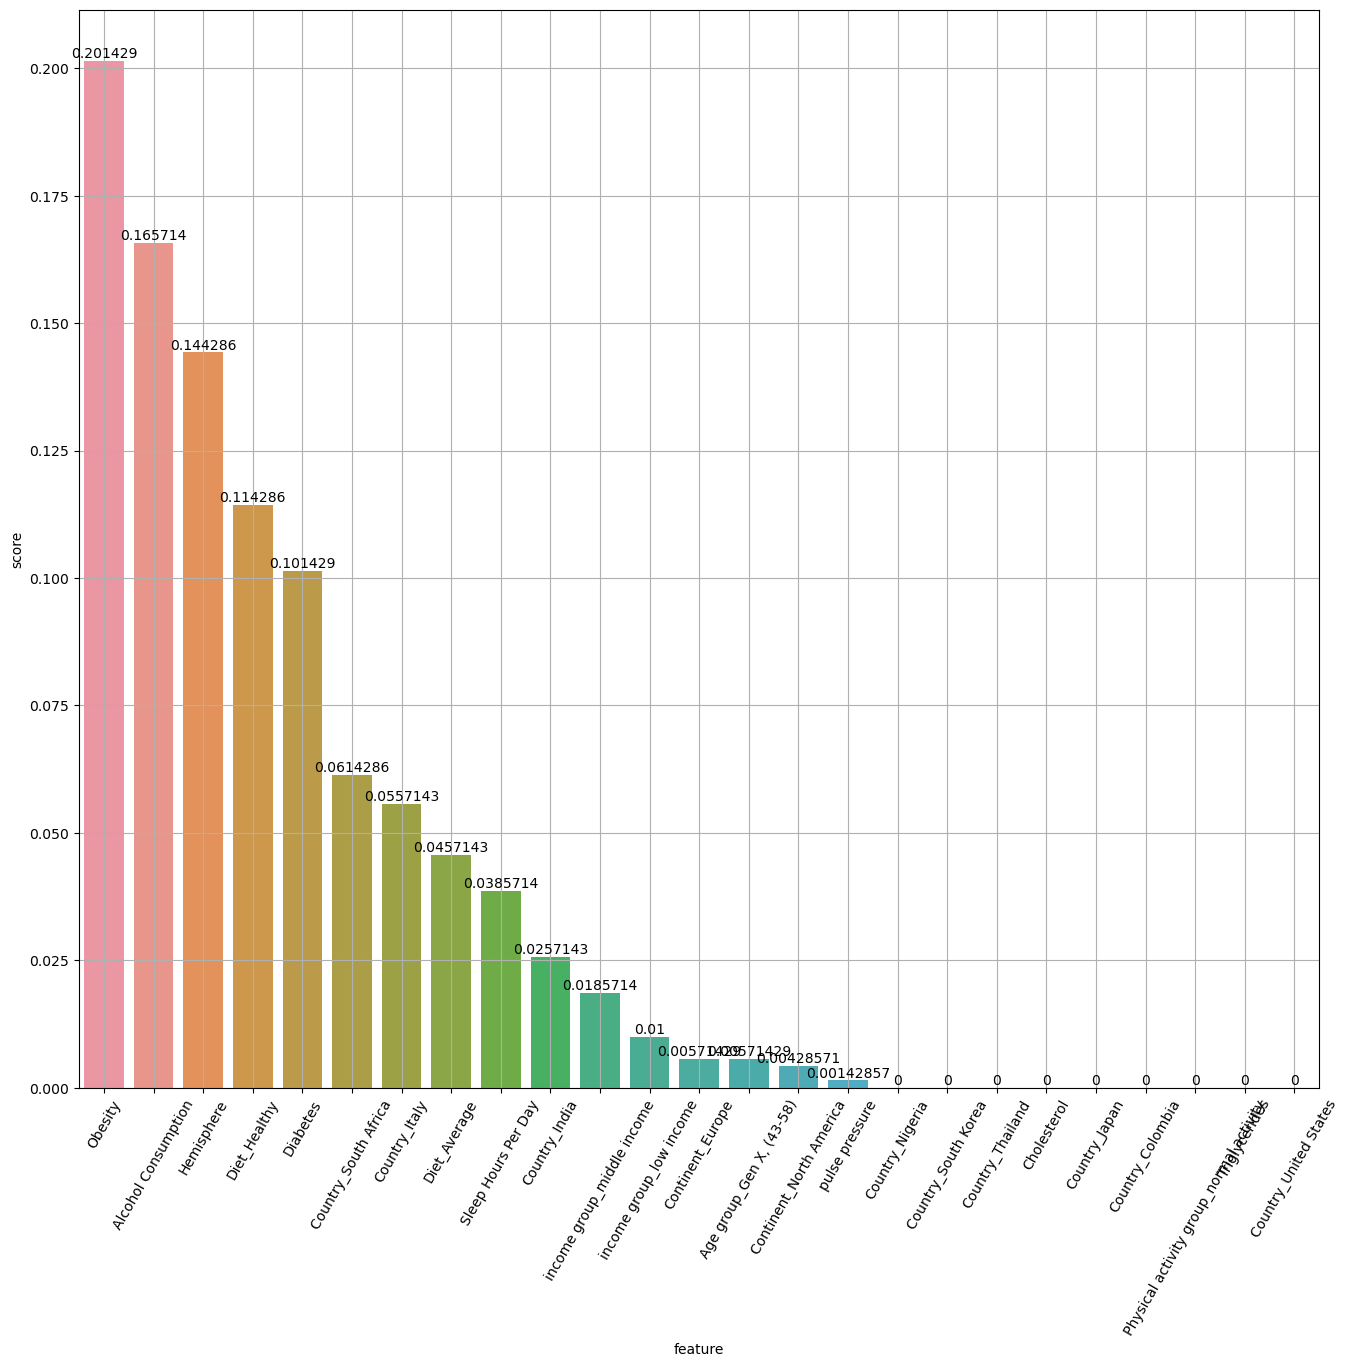

In [92]:
# Создаем объект Series со значимостью признаков
feat_importances = pd.Series(model_rf.feature_importances_, index=X.columns).sort_values(ascending=False).reset_index().rename(columns={'index' : 'feature', 0 : 'score'})
display(feat_importances)
# Визуализируем значимость признаков
plt.rcParams['figure.figsize'] = (16, 14)
bar = sns.barplot(feat_importances,
                  x='feature',
                  y='score',
                 )
plt.xticks(rotation=60)
bar.bar_label(bar.containers[0])
bar.grid();

## <center> **Заключение**

Из рассмотренных алгоритмов лучший результат в решении задачи классификации риска инфаркта показал XGBoost. 

Метрика Balanced Accuracy на тренировочной выборке = 0.71, а на тестовой - 0.70. Таким образом, модель 70% случаях будет относить пациента к правильному классу.

Метрика Recall используется для того, чтобы минимизировать риск нераспознания положительного класса. На тренировочной выборке она равна 0.82, а на тестовой - 0.81. Модель правильно определяет пациента с риском инфаркта в 81% процентах случаев. Это хорошее значение метрики, но для медицинских данных нужно стремитьтся к лучшему показателю.

Наиболее значимыми признаками при обучении можели стали ожирение, употребление алкоголя, полушарие, здоровая диета и диабет. Все три группы признаков оказали воияние на обучение, но в первую очередь - здоровый или нездоровый образ жизни.

In [93]:
# Сохраняем лучшую модель в файл формата .joblib
joblib.dump(model_rf, 'model/Random_Forest_Classifier.joblib')

['model/Random_Forest_Classifier.joblib']